# ERC-4626: best performing stablecoin vaults

TL; DR: [Jump the results to the list of currently best performing vaults](#Top-50-popular-vaults-by-last-three-months-returns) or [benchmark charts of beest vaults](#Vault-benchmark)

This notebook serves both as a coding tutorial and a useful data analytics tool for ERC-4626 vaults. 

- In this notebook, we find the best ERC-4626 vaults by their historical performance   
    - We analyse the vault performance by its share price, as reported by ERC-4626 smart contract interface.  Note that his share price method may introduce errors to various vaults needing manual cleanup.
    - We look [returns](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr), Sharpe and Sortino
- For the full list of benchmarked vaults. [see the earlier notebook](./erc-4626-vault-list.html)
- Because of how vault metrics, share price and such are collected and interpreted, the results in this notebook contain various inaccuracies.
  This is due to ERC-4626 missing features regarding fees, lockups, rebases and such that may affect the interpretation of the results.

In this notebook, we use terms Net Asset Value (NAV) and [Total Value Locked (TVL)](https://tradingstrategy.ai/glossary/total-value-locked-tvl) interchangeably.

## Usage

- Read general instructions [how to run the tutorials](./)
- See `ERC-4626 scanning all vaults onchain` example in tutorials first how to build a vault database as local `vault_db.pickle` file.
- See `ERC-4626: scanning vaults' historical price and performance` example in tutorials first how to build `vault-prices.parquet` file.

## Setup

- Set up notebook rendering output mode
- Use static image charts so this notebook is readeable on Github / ReadTheDocs

In [107]:
import pandas as pd
from plotly.offline import init_notebook_mode
import plotly.io as pio

from eth_defi.vault.base import VaultSpec

pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Set up Plotly chart output as SVG
image_format = "png"
width = 1400
height = 800

 # https://stackoverflow.com/a/52956402/315168
init_notebook_mode()

# https://stackoverflow.com/a/74609837/315168
assert hasattr(pio, "kaleido"), "Kaleido rendering backend missing. Run 'pip install kaleido' needed for this notebook"
pio.kaleido.scope.default_format = image_format

# https://plotly.com/python/renderers/#overriding-the-default-renderer
pio.renderers.default = image_format

current_renderer = pio.renderers[image_format]
# Have SVGs default pixel with
current_renderer.width = width
current_renderer.height = height

try:
    # Optionally make charts easier to share on Twitter
    from tradeexecutor.utils.notebook import set_large_plotly_chart_font
    set_large_plotly_chart_font(line_width=7)
    pio.templates.default = "custom"
except ImportError:
    print("Could not import set_large_plotly_chart_font() from tradeexecutor.utils.notebook and set large output font. ")
    pio.templates.default = "plotly_white"

## Read previously scanned vault price data

- Read the Parquet file produced earlier with price scan 

In [108]:
import pickle
from pathlib import Path

output_folder = Path("~/.tradingstrategy/vaults").expanduser()
parquet_file = output_folder / "vault-prices.parquet"
assert parquet_file.exists(), "Run the vault scanner script first"

vault_db = output_folder / "vault-db.pickle"
assert vault_db.exists(), "Run the vault scanner script first"
vault_db = pickle.load(open(vault_db, "rb"))

try:
    prices_df = pd.read_parquet(parquet_file)
except Exception as e:
    raise RuntimeError(f"Could not read: {parquet_file}: {e}") from e

chains = prices_df["chain"].unique()

print(f"We have {len(prices_df):,} price rows and {len(vault_db)} vault metadata entries for {len(chains)} chains")

sample_vault = next(iter(vault_db.values()))
print("We have vault metadata keys: ", ", ".join(c for c in sample_vault.keys()))
display(pd.Series(sample_vault))

print("We have prices DataFrame columns: ", ", ".join(c for c in prices_df.columns))
print("DataFrame sample:")
display(prices_df.head())

We have 1,803,387 price rows and 8067 vault metadata entries for 16 chains
We have vault metadata keys:  Symbol, Name, Address, Denomination, NAV, Protocol, Mgmt fee, Perf fee, Shares, First seen, _detection_data, _denomination_token, _share_token


Symbol                                             fBPT-50STABAL3-50WETH
Name                                           FARM_BPT-50STABAL3-50WETH
Address                       0xdfa7578b8187f5dd1d0cb9d86b6dd33625895cf2
Denomination                                        BPT-50STABAL3-50WETH
NAV                                                 0.042399649489411407
Protocol                                                 Harvest Finance
Mgmt fee                                                            None
Perf fee                                                            None
Shares                                              0.042300245583425379
First seen                                           2023-08-04 15:37:57
_detection_data        ERC4262VaultDetection(chain=8453, address='0xd...
_denomination_token    {'name': 'Balancer 50 STABAL3 50 WETH', 'symbo...
_share_token           {'name': 'FARM_BPT-50STABAL3-50WETH', 'symbol'...
dtype: object

We have prices DataFrame columns:  chain, address, block_number, timestamp, share_price, total_assets, total_supply, performance_fee, management_fee, errors
DataFrame sample:


chain                                     address  block_number  \
0  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      10832321   
1  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      11177921   
2  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      11523521   
3  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      11869121   
4  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      12214721   

            timestamp  share_price  total_assets  total_supply  \
0 2022-04-29 14:53:11          NaN          1.00           NaN   
1 2022-05-04 13:10:44          NaN      8,887.99           NaN   
2 2022-05-08 17:05:28          NaN      8,887.99           NaN   
3 2022-05-12 05:17:57          NaN      8,887.99           NaN   
4 2022-05-16 11:17:40          NaN      8,887.99           NaN   

   performance_fee  management_fee                    errors  
0              NaN             NaN  total_supply call failed  
1              NaN             NaN  total_supply call failed  
2              NaN             NaN  total_supply call failed  
3              NaN             NaN  total_supply call failed  
4              NaN             NaN  total_supply call failed

## Transform data

- Combine columns from metadata database with price series for easier manipulation

In [109]:
vaults_by_id = {
    f"{vault['_detection_data'].chain}-{vault['_detection_data'].address}": vault for vault in vault_db.values()
}

# Vaults are identified by their chain and address tuple, make this one human-readable column 
# to make DataFrame wrangling easier
prices_df['id'] = prices_df['chain'].astype(str) + '-' + prices_df['address'].astype(str)
prices_df['name'] = prices_df['id'].apply(lambda x: vaults_by_id[x]['Name'] if x in vaults_by_id else None)
prices_df['event_count'] = prices_df['id'].apply(lambda x: vaults_by_id[x]['_detection_data'].deposit_count + vaults_by_id[x]['_detection_data'].redeem_count)
prices_df['protocol'] = prices_df['id'].apply(lambda x: vaults_by_id[x]['Protocol'] if x in vaults_by_id else None)

display(prices_df.head(1))

chain                                     address  block_number  \
0  42161  0x42448fddcec02124cf6db19a9f91dea7bb0e88e5      10832321   

            timestamp  share_price  total_assets  total_supply  \
0 2022-04-29 14:53:11          NaN          1.00           NaN   

   performance_fee  management_fee                    errors  \
0              NaN             NaN  total_supply call failed   

                                                 id        name  event_count  \
0  42161-0x42448fddcec02124cf6db19a9f91dea7bb0e88e5  Jones rDPX          916   

             protocol  
0  <unknown ERC-4626>

## Filter down to USD-based vaults

- In this notebooks, we focus on stablecoin yield
- Do not consider WETH, other native token vaults, as their returns calculation 
  would need to match the appreciation of underlying assets
- [is_stablecoin_like](https://web3-ethereum-defi.readthedocs.io/api/core/_autosummary/eth_defi.token.is_stablecoin_like.html?highlight=is_stablecoin_like#eth_defi.token.is_stablecoin_like) supports GHO, crvUSD and other DeFi/algorithmic stablecoins
- Note that this picks up very few EUR and other fiat-nominated vaults


In [110]:
from eth_defi.token import is_stablecoin_like

usd_vaults = [v for v in vault_db.values() if is_stablecoin_like(v["Denomination"])]
print(f"We have {len(usd_vaults)} stablecoin-nominated vaults out of {len(vault_db)} total vaults")

# Build chain-address strings for vaults we are interested in
allowed_vault_ids = set(str(v["_detection_data"].chain) + "-" + v["_detection_data"].address for v in usd_vaults)

# Filter out prices to contain only data for vaults we are interested in
prices_df = prices_df.loc[prices_df["id"].isin(allowed_vault_ids)]
print(f"Filtered out prices have {len(prices_df):,} rows")

We have 2833 stablecoin-nominated vaults out of 8067 total vaults
Filtered out prices have 653,994 rows


## Calculate return series for all vaults

- Build daily returns for all vaults we have some good data

In [111]:

def calculate_daily_returns(df_work):
    """Calculate daily returns for each vault in isolation"""

    # Group by chain and address, then resample and forward fill

    df_work = df_work.set_index("timestamp")

    result_dfs = []
    for (chain_val, addr_val), group in df_work.groupby(['chain', 'address']):
        # Resample this group to daily frequency and forward fill
        resampled = group.resample('D').ffill()
        
        # Calculate daily returns
        resampled['daily_returns'] = resampled['share_price'].pct_change(fill_method=None).fillna(0)
        
        # Add back the groupby keys as they'll be dropped during resampling
        resampled['chain'] = chain_val
        resampled['address'] = addr_val
        
        result_dfs.append(resampled)

    # Concatenate all the processed groups
    df_result = pd.concat(result_dfs)
    
    return df_result

returns_df = calculate_daily_returns(prices_df)

print("All returns DataFrame sample data:")
display(returns_df.head())


All returns DataFrame sample data:


chain                                     address  block_number  \
timestamp                                                                     
2024-01-11      1  0x0022228a2cc5e7ef0274a7baa600d44da5ab5776           NaN   
2024-01-12      1  0x0022228a2cc5e7ef0274a7baa600d44da5ab5776 18,985,099.00   
2024-01-13      1  0x0022228a2cc5e7ef0274a7baa600d44da5ab5776 18,992,299.00   
2024-01-14      1  0x0022228a2cc5e7ef0274a7baa600d44da5ab5776 18,999,499.00   
2024-01-15      1  0x0022228a2cc5e7ef0274a7baa600d44da5ab5776 19,006,699.00   

            share_price  total_assets  total_supply  performance_fee  \
timestamp                                                              
2024-01-11          NaN           NaN           NaN              NaN   
2024-01-12         1.00          1.00          1.00              NaN   
2024-01-13         1.00          1.00          1.00              NaN   
2024-01-14         1.00          1.00          1.00              NaN   
2024-01-15         1.00          1.00          1.00              NaN   

            management_fee errors  \
timestamp                           
2024-01-11             NaN    NaN   
2024-01-12             NaN          
2024-01-13             NaN          
2024-01-14             NaN          
2024-01-15             NaN          

                                                      id         name  \
timestamp                                                               
2024-01-11                                           NaN          NaN   
2024-01-12  1-0x0022228a2cc5e7ef0274a7baa600d44da5ab5776  Staked USDA   
2024-01-13  1-0x0022228a2cc5e7ef0274a7baa600d44da5ab5776  Staked USDA   
2024-01-14  1-0x0022228a2cc5e7ef0274a7baa600d44da5ab5776  Staked USDA   
2024-01-15  1-0x0022228a2cc5e7ef0274a7baa600d44da5ab5776  Staked USDA   

            event_count            protocol  daily_returns  
timestamp                                                   
2024-01-11          NaN                 NaN           0.00  
2024-01-12     1,591.00  <unknown ERC-4626>           0.00  
2024-01-13     1,591.00  <unknown ERC-4626>           0.00  
2024-01-14     1,591.00  <unknown ERC-4626>           0.00  
2024-01-15     1,591.00  <unknown ERC-4626>           0.00

## Calculate lifetime, annual and 3M returns for each vault

- Calculate compounding annual return ([CAGR](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr) )and lifetime returns for all price series
- We also calculate returns for the last three months, reflecting the recent performance
- You can benchmark numbers on protocol-maintained frontends, example: [Yearn: DAI to yvUSDS Farmer](https://yearn.fi/vaults/1/0x6acEDA98725505737c0F00a3dA0d047304052948?tab=about)
- CAGR, returns, etc. are expressed in raw values: 0.01 means 1% return

To clean the data, we filter out based on 
- Too high NAV value (broken tokens?)
- Too min NAV value (test vaults)
- Not enough deposit and redemption activity

**Note**: These are gross returns. Due to lack of standardisation on vault fee structure, maintaining fee data is mostly manual job.

In [112]:
import warnings
import numpy as np

from eth_defi.chain import get_chain_name

three_months_ago = pd.Timestamp.now() - pd.DateOffset(months=3)

def calculate_lifetime_metrics(df):
    results = []
    
    for id_val, group in df.groupby('id'):
        # Sort by timestamp just to be safe
        group = group.sort_index()
        name = vaults_by_id[id_val]['Name'] if id_val in vaults_by_id else None
        
        # Calculate lifetime return using cumulative product approach
        lifetime_return = (1 + group['daily_returns']).prod() - 1

        last_three_months = group['daily_returns'].loc[three_months_ago:]
        three_month_returns = (1 + last_three_months).prod() - 1

        max_nav = group['total_assets'].max()
        current_nav = group['total_assets'].iloc[-1]
        chain_id = group['chain'].iloc[-1]
        mgmt_fee = group['management_fee'].iloc[-1]
        perf_fee = group['performance_fee'].iloc[-1]
        event_count = group['event_count'].iloc[-1]
        protocol = group['protocol'].iloc[-1]
        
        # Calculate CAGR
        # Get the first and last date
        start_date = group.index.min()
        end_date = group.index.max()
        years = (end_date - start_date).days / 365.25        
        cagr = (1 + lifetime_return) ** (1 / years) - 1 if years > 0 else np.nan

        # Calculate 3 months CAGR
        # Get the first and last date
        start_date = last_three_months.index.min()
        end_date = last_three_months.index.max()
        three_months_cagr = (1 + three_month_returns) ** (1 / years) - 1 if years > 0 else np.nan

        results.append({            
            'name': name,
            'cagr': cagr,
            'lifetime_return': lifetime_return,            
            'three_months_cagr': three_months_cagr,
            'denomination': vaults_by_id[id_val]['Denomination'] if id_val in vaults_by_id else None,
            'chain': get_chain_name(chain_id),            
            'peak_nav': max_nav,            
            'current_nav': current_nav,
            'years': years, 
            "mgmt_fee": mgmt_fee,
            "perf_fee": perf_fee,
            "event_count": event_count,
            "protocol": protocol,
            'id': id_val,
            'three_months_returns': three_month_returns,
            'start_date': start_date,
            'end_date': end_date,

        })
    
    return pd.DataFrame(results)


# Numpy complains about something
# - invalid value encountered in reduce
# - Boolean Series key will be reindexed to match DataFrame index. 
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    warnings.simplefilter("ignore", RuntimeWarning)
    lifetime_data_df = calculate_lifetime_metrics(returns_df)

lifetime_data_df = lifetime_data_df.sort_values(by='cagr', ascending=False)
lifetime_data_df = lifetime_data_df.set_index('name')

print(f"Calculated lifetime data for {len(lifetime_data_df):,} vaults")
print("Sample entrys of lifetime data:")
display(lifetime_data_df.tail(1))

#
# Clean data
#

# Filter FRAX vault with broken interface
lifetime_data_df = lifetime_data_df[~lifetime_data_df.index.isna()]

# Filter out MAAT Stargate V2 USDT	
# Not sure what's going on with this one and other ones with massive returns.
# Rebase token?
# Consider 10,000x returns as "valid"
lifetime_data_df = lifetime_data_df[lifetime_data_df["cagr"] < 10_000]

# Filter out some vaults that report broken NAV
broken_max_nav_value = 99_000_000_000
broken_mask = lifetime_data_df['peak_nav'] > broken_max_nav_value
print(f"Vault entries with too high NAV values filtered out: {len(lifetime_data_df[broken_mask])}")
lifetime_data_df = lifetime_data_df[~broken_mask]

# Filter out some vaults that have too little NAV (ATH NAV)
lifetime_min_nav_threshold = 100.00
broken_mask = lifetime_data_df['peak_nav'] <= lifetime_min_nav_threshold
print(f"Vault entries with too small ATH NAV values filtered out: {len(lifetime_data_df[broken_mask])}")
lifetime_data_df = lifetime_data_df[~broken_mask]

# Filter out some vaults that have not seen many deposit and redemptions 
min_events = 25
broken_mask = lifetime_data_df['event_count'] < min_events
print(f"Vault entries with too few deposit and redeem events (min {min_events}) filtered out: {len(lifetime_data_df[broken_mask])}")
lifetime_data_df = lifetime_data_df[~broken_mask]


Calculated lifetime data for 1,644 vaults
Sample entrys of lifetime data:


cagr  lifetime_return  three_months_cagr denomination  \
name                                                                        
Funded Vault Token -1.00            -1.00              -1.00         USDC   

                       chain  peak_nav  current_nav  years  mgmt_fee  \
name                                                                   
Funded Vault Token  Arbitrum 44,686.56     1,453.54   0.72       NaN   

                    perf_fee  event_count            protocol  \
name                                                            
Funded Vault Token       NaN        65.00  <unknown ERC-4626>   

                                                                  id  \
name                                                                   
Funded Vault Token  42161-0x3c7009ade93439ce325a77fe5b426f0a76d0b5fc   

                    three_months_returns start_date   end_date  
name                                                            
Funded Vault Token                 -1.00 2025-01-23 2025-04-20

Vault entries with too high NAV values filtered out: 1
Vault entries with too small ATH NAV values filtered out: 251
Vault entries with too few deposit and redeem events (min 25) filtered out: 362


## Top 50 vaults: historical performance, including dead ones

- Sorted by lifetime returns, the current three month returns displayed as well
- Vaults may be dead today with zero NAV/TVL
- Reasons why NAV drops to zero may include: hacks, rug pulls, etc.
- Share price calculation for low TVL vaults may have various inaccuracies because vaults implement vesting/locking mechanisms which are not visible in the share price

In [113]:
nav_threshold = 25_000

lifetime_data_filtered_df = lifetime_data_df[lifetime_data_df['peak_nav'] >= nav_threshold]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] <= 0]

print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD")
print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='cagr', ascending=False)
display(lifetime_data_filtered_df.head(50))

All vaults sorted by lifetime returns and having currnet NAV > $25,000 USD
Vaults with positive returns 661 out of 750 total vaults
Vaults with negative returns 89 out of 750 total vaults


cagr  lifetime_return  \
name                                                                         
sUSDC                                              654.18            59.42   
Morpho LlamaRisk crvUSD Vault Compounder           285.92             3.86   
Peapods Interest Bearing USDC - 17                 241.11             2.00   
BRT2: moonwell USDC                                191.39             9.76   
Aave V3 crvUSD Lender                               37.01             5.84   
Aave V3 USDS Lender                                 23.22             4.34   
Spark USDT Lender                                   20.59             5.26   
OkToken                                             15.90            12.37   
MAAT Stargate V2 USDt                               13.88             5.12   
Spark USDC Lender                                   12.68             3.90   
Aave V3 DAI Lender                                  12.36             2.56   
AaveV3 USDC Lender                                  12.09            23.11   
DAI Multi-Strategy Vault                             8.85            61.36   
Neko USDC Vault                                      7.26             1.04   
Aave V3 Lido USDC Lender                             7.15             1.45   
FARM_USDC.e                                          6.85             0.68   
USDS Compound V3 Lender                              6.19             0.97   
StrategyGearboxLenderDAI                             5.19             2.70   
USDC to yvUSDS Farmer                                4.38             1.41   
FARM_USDC                                            3.32             0.82   
Silo Finance Borrowable USDC Deposit in wstETH ...   2.84             1.67   
Savings GYD                                          2.35             1.37   
USDT CompoundV3 Lender                               2.18             1.39   
MaxEarn USDC                                         2.07             0.41   
Sturdy crvUSD/yean curve USDC-crvUSD LP silo         1.83             2.72   
DAI to yvUSDS Farmer                                 1.78             0.71   
FARM_USDC                                            1.76             2.50   
Peapods Interest Bearing USDC - 16                   1.51             0.16   
yearn-V3-Stargate-USDC                               1.28             1.86   
MVP_HOPPER_USDC                                      1.22             0.52   
dgnBTC v2                                            1.17             0.44   
Morpho Steakhouse USDT Compounder                    1.16             0.24   
FARM_DAI                                             1.02             1.39   
FARM_FRAX                                            0.99             1.34   
Morpho Gauntlet USDT Prime Compounder                0.98             0.21   
Savings GYD                                          0.97             0.63   
Gains Network USDC                                   0.90             0.44   
Peapods Interest Bearing USDC - 14                   0.89             0.11   
FARM_USDT                                            0.87             0.29   
ETH++                                                0.85             1.25   
Aave V3 EURe Lender                                  0.83             0.95   
YRizStrategyUSDC                                     0.83             0.56   
IdleCDO BB Tranche - idle_cpPOR-USDC4626Adapter      0.79             2.23   
Gains Network USDC                                   0.77             1.05   
dgnHYPE                                              0.75             0.24   
Gearbox crvUSD Lender                                0.74             0.49   
Aave V3 USDC Lender                                  0.73             0.34   
Compound V3 USDC.e Lender                            0.69             0.54   
StrategyGearboxLenderUSDC                            0.69             0.67   
cSuperior Quality Private Credit USDC                0.58             0.26 

## Top 50 vaults: historical performance, vaults still alive

- Sorted by lifetime returns
- Vaults have still meaningful TVL today


In [114]:
nav_threshold = 25_000

lifetime_data_filtered_df = lifetime_data_df[lifetime_data_df['current_nav'] >= nav_threshold]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] <= 0]

print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD")
print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='cagr', ascending=False)
display(lifetime_data_filtered_df.head(50))

All vaults sorted by lifetime returns and having currnet NAV > $25,000 USD
Vaults with positive returns 410 out of 449 total vaults
Vaults with negative returns 39 out of 449 total vaults


cagr  lifetime_return  \
name                                                                        
Aave V3 USDS Lender                                23.22             4.34   
Neko USDC Vault                                     7.26             1.04   
FARM_USDC.e                                         6.85             0.68   
USDC to yvUSDS Farmer                               4.38             1.41   
Savings GYD                                         2.35             1.37   
Sturdy crvUSD/yean curve USDC-crvUSD LP silo        1.83             2.72   
DAI to yvUSDS Farmer                                1.78             0.71   
Morpho Steakhouse USDT Compounder                   1.16             0.24   
Morpho Gauntlet USDT Prime Compounder               0.98             0.21   
Savings GYD                                         0.97             0.63   
Gains Network USDC                                  0.90             0.44   
Peapods Interest Bearing USDC - 14                  0.89             0.11   
IdleCDO BB Tranche - idle_cpPOR-USDC4626Adapter     0.79             2.23   
Gains Network USDC                                  0.77             1.05   
dgnHYPE                                             0.75             0.24   
cSuperior Quality Private Credit USDC               0.58             0.26   
RizVaultUSDC                                        0.57             0.53   
kBOX                                                0.46             0.11   
HYPE++                                              0.44             0.16   
Vault                                               0.43             0.08   
Gains Network DAI                                   0.42             1.23   
Morpho Gauntlet DAI Core Compounder                 0.40             0.12   
FARM_USDC.e                                         0.39             0.31   
40op-USDC-Vault                                     0.37             0.05   
Silo Finance Borrowable USDC Deposit in wstETH ...  0.33             0.20   
Peapods Interest Bearing USDC - 21                  0.32             0.02   
Peapods Interest Bearing USDC - 42                  0.32             0.05   
Peapods Interest Bearing USDC - 15                  0.28             0.05   
Peapods Interest Bearing USDC - 1                   0.27             0.05   
Gains Network DAI                                   0.26             0.72   
Peapods Interest Bearing USDC - 67                  0.24             0.02   
Silo Finance Borrowable USDC Deposit in WBTC Silo   0.22             0.14   
Gains Network USDC                                  0.20             0.26   
YieldFi yToken                                      0.18             0.08   
JUNIOR TRANCHE Tranche USD Coin                     0.18             0.23   
Morpho Moonwell Flagship USDC Compounder            0.18             0.06   
Curve Vault for crvUSD                              0.17             0.18   
Wrapped Mountain Protocol USD                       0.17             0.08   
Compound V3 USDC Lender                             0.17             0.26   
Peapods Interest Bearing USDC - 7                   0.17             0.03   
Peapods Interest Bearing USDC - 6                   0.16             0.03   
Curve Vault for crvUSD                              0.16             0.16   
High Yield Secured Lending Maple Pool USDC1         0.15             0.17   
Yield Chasing crvUSD                                0.15             0.07   
Curve Vault for crvUSD                              0.15             0.11   
Staked lvlUSD                                       0.15             0.06   
FARM_USDC                                           0.15             0.24   
AQRU Maple Pool USDC1                               0.15             0.36   
USDC CompoundV3 Lender                              0.14             0.18   
fija Strategy USDC GMXv2                            0.14             0.05   

                                               

## Top 50 vaults: last three months returns, including low-activity ones

- Sorted by three months CAGR
- Include low-activity ones

In [115]:
nav_threshold = 25_000

lifetime_data_filtered_df = lifetime_data_df[lifetime_data_df['current_nav'] >= nav_threshold]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] <= 0]

print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD")
print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='three_months_cagr', ascending=False)

column_to_shift = "three_months_cagr"
new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

display(lifetime_data_filtered_df.head(50))

All vaults sorted by lifetime returns and having currnet NAV > $25,000 USD
Vaults with positive returns 410 out of 449 total vaults
Vaults with negative returns 39 out of 449 total vaults


three_months_cagr  cagr  \
name                                                                          
FARM_USDC.e                                                      6.87  6.85   
USDC to yvUSDS Farmer                                            4.17  4.38   
IdleCDO BB Tranche - idle_cpPOR-USDC4626Adapter                  3.09  0.79   
DAI to yvUSDS Farmer                                             1.67  1.78   
Aave V3 USDS Lender                                              1.40 23.22   
Morpho Steakhouse USDT Compounder                                1.14  1.16   
Morpho Gauntlet USDT Prime Compounder                            0.96  0.98   
Revert Lend Arbitrum USDC,                                       0.92 -0.73   
Peapods Interest Bearing USDC - 14                               0.89  0.89   
dgnHYPE                                                          0.75  0.75   
kBOX                                                             0.46  0.46   
cSuperior Quality Private Credit USDC                            0.45  0.58   
Vault                                                            0.43  0.43   
Morpho Gauntlet DAI Core Compounder                              0.38  0.40   
40op-USDC-Vault                                                  0.37  0.37   
Peapods Interest Bearing USDC - 21                               0.32  0.32   
Peapods Interest Bearing USDC - 42                               0.32  0.32   
Peapods Interest Bearing USDC - 15                               0.28  0.28   
Peapods Interest Bearing USDC - 1                                0.27  0.27   
HYPE++                                                           0.25  0.44   
Peapods Interest Bearing USDC - 67                               0.24  0.24   
Gains Network USDC                                               0.20  0.77   
Peapods Interest Bearing USDC - 7                                0.17  0.17   
Morpho Moonwell Flagship USDC Compounder                         0.16  0.18   
Peapods Interest Bearing USDC - 6                                0.16  0.16   
FARM_USDC.e                                                      0.13  0.39   
Lend USDC on Dahlia WBERA/USDC (68% LLTV)                        0.13  0.13   
Spectra ERC4626 Wrapper: Wrapped Ultimate Synth...               0.10  0.10   
Plutus Hedge Token                                               0.09  0.09   
EVK Vault eUSDC-25                                               0.09  0.09   
kREX                                                             0.09  0.12   
EVK Vault eUSDC-28                                               0.09  0.09   
Clearstar OpenEden USDC                                          0.09  0.09   
EVK Vault eUSDC-3                                                0.08  0.08   
Hakutora USDC                                                    0.08  0.09   
Gauntlet USDC Frontier                                           0.08  0.08   
Static RWA ZeroLend USDC                                         0.08  0.12   
Supply USDC on ZeroLend RWA Market                               0.08  0.12   
YieldFi yToken                                                   0.08  0.18   
Dolomite: USDC                                                   0.08  0.12   
Gains Network DAI                                                0.08  0.42   
Apostro Ethena USDe                                              0.08  0.08   
EVK Vault eUSDe-1                                                0.08  0.08   
Smokehouse USDC                                                  0.08  0.08   
Staked avUSD                                                     0.08  0.09   
Hyperithm USDC                                                   0.08  0.08   
Apostro Resolv USR                                               0.07  0.07   
Morpho Compound USDC Compounder                                  0.07  0.07   
FARM_USDC                                                        0.07  0.07   
Yield Chasing USDC     

## Top 50 popular vaults by last three months returns

<a id="top-3M"></a>

- Best performing vaults
- Sorted by three months [CAGR](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr)
- Include only vaults with significant number of deposit events over life time, or "popular vaults"

Notes
- The vault named "Vault" on Base is [40acres.finance](https://www.40acres.finance/)

In [116]:
nav_threshold = 100_000
event_threshold = 450

lifetime_data_filtered_df = lifetime_data_df[
    (lifetime_data_df['current_nav'] >= nav_threshold) &
    (lifetime_data_df['event_count'] >= event_threshold)
]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] <= 0]

print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD")
print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='three_months_cagr', ascending=False)

column_to_shift = "three_months_cagr"
new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

display(lifetime_data_filtered_df.head(50))

All vaults sorted by lifetime returns and having currnet NAV > $100,000 USD
Vaults with positive returns 206 out of 220 total vaults
Vaults with negative returns 14 out of 220 total vaults


three_months_cagr  cagr  lifetime_return  \
name                                                                           
Revert Lend Arbitrum USDC,                       0.92 -0.73            -0.56   
Vault                                            0.43  0.43             0.08   
Peapods Interest Bearing USDC - 67               0.24  0.24             0.02   
Gains Network USDC                               0.20  0.77             1.05   
EVK Vault eUSDC-25                               0.09  0.09             0.02   
Clearstar OpenEden USDC                          0.09  0.09             0.01   
EVK Vault eUSDC-3                                0.08  0.08             0.02   
Hakutora USDC                                    0.08  0.09             0.02   
Gauntlet USDC Frontier                           0.08  0.08             0.01   
Gains Network DAI                                0.08  0.42             1.23   
Smokehouse USDC                                  0.08  0.08             0.01   
Staked avUSD                                     0.08  0.09             0.04   
Apostro Resolv USR                               0.07  0.07             0.01   
EVK Vault eUSR-2                                 0.07  0.07             0.02   
EVK Vault eUSDC.e-2                              0.07  0.07             0.01   
Apostro Resolv USDC                              0.07  0.09             0.02   
Apostro Resolv USDC                              0.07  0.07             0.01   
Resolv USDC                                      0.06  0.08             0.02   
EVK Vault eAUSD-2                                0.06  0.06             0.00   
Staked lvlUSD                                    0.06  0.15             0.06   
Spicy USDC Vault                                 0.06  0.12             0.06   
EVK Vault eUSDC-19                               0.06  0.13             0.05   
LazyVault_LowerRisk_USDC                         0.06  0.06             0.01   
Gains Network DAI                                0.05  0.26             0.72   
EVK Vault eUSDT-9                                0.05  0.06             0.02   
Spark USDC Vault                                 0.05  0.05             0.01   
Spark USDC Vault                                 0.05  0.05             0.01   
Spark USDC Vault                                 0.05  0.05             0.01   
SuperUSDC                                        0.05  0.09             0.03   
Shorewoods USDC                                  0.05  0.07             0.02   
Smokehouse USDC                                  0.05  0.11             0.04   
EVK Vault eUSDC-22                               0.05  0.07             0.02   
EVK Vault eUSDC.e-1                              0.05  0.05             0.00   
EVK Vault eUSDC.e-3                              0.05  0.05             0.00   
UltraYield USDC                                  0.05  0.07             0.02   
SuperUSDC                                        0.05  0.06             0.02   
Spark USDC Vault                                 0.05  0.05             0.01   
USDC Meta Vault                                  0.05  0.06             0.02   
EVK Vault eUSR-1                                 0.04  0.05             0.02   
Seamless USDC Vault                              0.04  0.05             0.01   
EVK Vault eUSDS-1                                0.04  0.04             0.01   
Ionic Ecosystem USDC                             0.04  0.05             0.02   
Apostro Resolv USR                               0.04  0.04             0.01   
August Digital USDC                              0.04  0.06             0.02   
MEV Capital USDC                                 0.04  0.06             0.02   
Curve Vault for crvUSD                           0.04  0.15             0.11   
Re7 USDC                                         0.04  0.06             0.02   
IPOR USDC Lending Optimizer Base                 0.04  0.09             0.04   
Savings GYD                         

## Vault benchmark

<a id="rolling"></a>

- Here we compare the top 20 performing popular, by their 3 months returns
- We plot our annualised 1 month rolling returns on the chart, to see how vaults move in the direction of the markets, or what kind of outliers there are
- Below, we plot the same chart again without market-making vaults as their volatility shades other vaults
- We plot 1 year period, but we do not have enough history for most vaults for this time window

### Market-making vaults vs. lending vaults

You can see how market-making vaults differ from others, as their returns are much more volatile and can be negative (losing money when market is not optimal).

- [About Gains Network DAI (gDAI)](https://gains.trade/vaults/gDAI): Deposit DAI in exchange for gDAI, an ERC-20 representing your ownership in the vault. Stakers receive fees from each trade placed on the platform in exchange for serving as the counterparty to all trades. gDAI accumulates these fees in real-time.
- [About Ostium Vault (ostiumLP)](https://ostium.app/vault): Earn fractional trading and liquidation fees with $OLP by providing liquidity with staked USDC. This pool acts as the ultimate backstop for trade settlement.

We lack fee data for 6 / 10 vaults


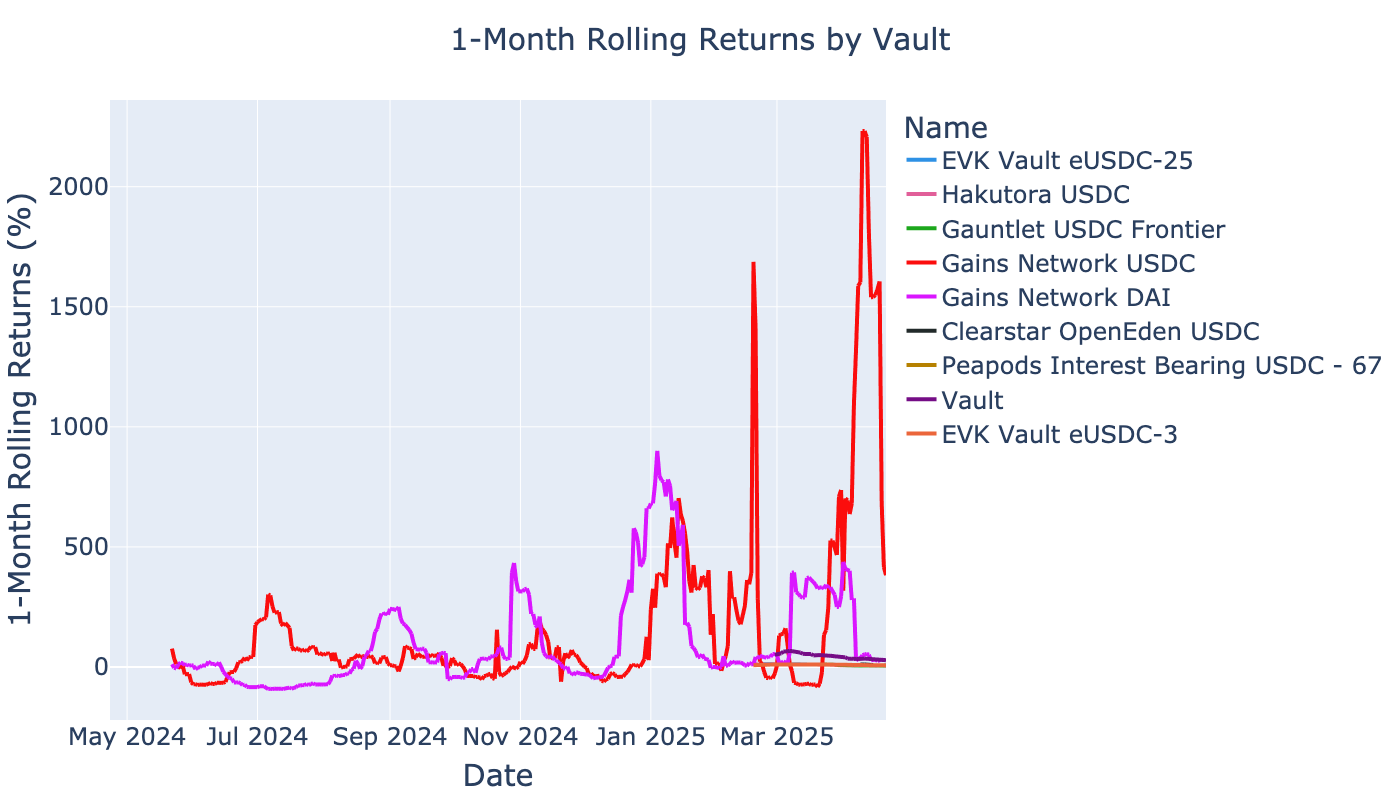

Peak returns by


timestamp                                                   2025-04-10 00:00:00
chain                                                                       137
address                              0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81
block_number                                                      70,105,934.00
share_price                                                                2.09
total_assets                                                         668,744.96
total_supply                                                         319,837.59
performance_fee                                                             NaN
management_fee                                                              NaN
errors                                                                         
id                               137-0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81
name                                                         Gains Network USDC
event_count                             

In [117]:
import plotly.express as px
from plotly.colors import qualitative 


def calculate_rolling_returns(
    returns_df: pd.DataFrame,
    interesting_vaults: pd.Series,
    window: int = 30,  # Bars
    period: pd.Timedelta = pd.Timedelta(days=365),
    benchmark_count: int = 20,
    cap: float = None,
):
    
    # Limit to benchmarked vaults
    df = returns_df[returns_df["id"].isin(interesting_vaults)]
    df = df.reset_index().sort_values(by=["id", "timestamp"])

    # Manually blacklist one vault where we get data until fixed
    df = df[df["name"] != "Revert Lend Arbitrum USDC,"]

    # Limit chart width
    df = df.loc[df["timestamp"] >= (pd.Timestamp.now() - period)]

    # Calculate rollling returns
    df['rolling_1m_returns'] = df.groupby('id')['daily_returns'].transform(
        lambda x: (((1 + x).rolling(window=window).apply(np.prod) - 1) * 100)
    )

    df['rolling_1m_returns_annualized'] = ((1 + df['rolling_1m_returns']/100) ** 12 - 1) * 100

    # When vault launches it has usually near-infinite APY
    # Cap it here so charts are readable
    if cap is not None:
        # Using mask (replaces values WHERE condition is True)
        df['rolling_1m_returns_annualized'] = df['rolling_1m_returns_annualized'].mask(
            (df['rolling_1m_returns_annualized'] > cap) | (df['rolling_1m_returns_annualized'] < -cap), 
            np.nan
        )

    return df


interesting_vaults = lifetime_data_filtered_df[0:benchmark_count]["id"]
df = calculate_rolling_returns(returns_df, interesting_vaults=interesting_vaults)

# Report manual fee data gathering needed
lack_fees_df = df[df["performance_fee"].isna()]
print(f"We lack fee data for {len(lack_fees_df['id'].unique()):,} / {len(interesting_vaults)} vaults")

# display(df.head(2))

fig = px.line(df, 
              x='timestamp', 
              y='rolling_1m_returns_annualized',
              color='name',
              title='1-Month Rolling Returns by Vault',
              labels={'rolling_1m_returns': '1-Month Rolling Returns (%)',
                     'timestamp': 'Date',
                     'name': 'Name'},
              hover_data=['id'],
              color_discrete_sequence=qualitative.Dark24,
              )

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='1-Month Rolling Returns (%)',
    legend_title='Name',
    hovermode='closest',
    template='custom'
)

fig.update_traces(line=dict(width=4))


fig.show()

max_row = df.loc[df['rolling_1m_returns'].idxmax()]
print("Peak returns by")
display(max_row)

### Vault performance, excluding market making vaults

- Exclude gDAI to see other vaults better in the chart



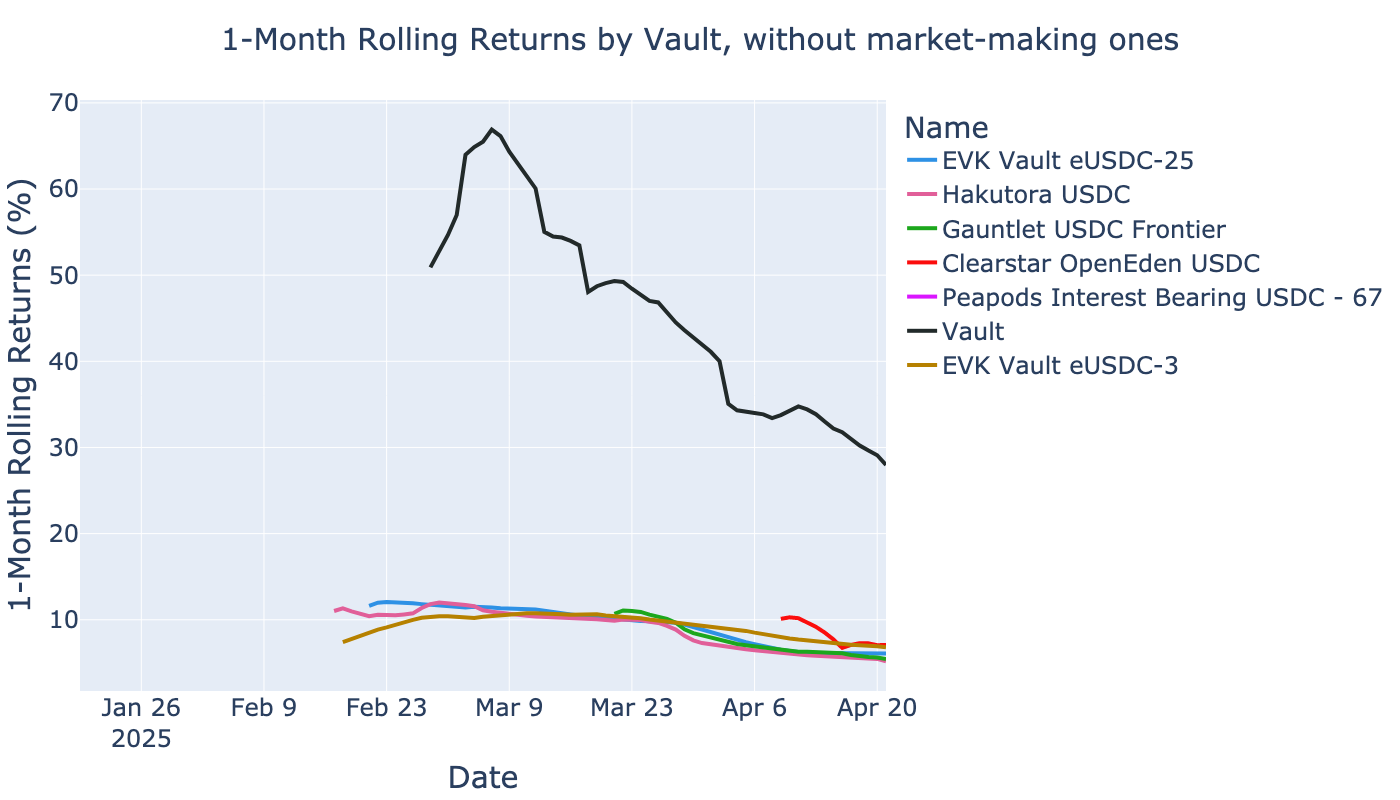

Peak returns by


timestamp                                                    2025-03-07 00:00:00
chain                                                                       8453
address                               0xb99b6df96d4d5448cc0a5b3e0ef7896df9507cf5
block_number                                                       27,294,215.00
share_price                                                             1,618.87
total_assets                                                          354,651.03
total_supply                                                              219.07
performance_fee                                                              NaN
management_fee                                                               NaN
errors                                                                          
id                               8453-0xb99b6df96d4d5448cc0a5b3e0ef7896df9507cf5
name                                                                       Vault
event_count                 

In [118]:
df = df[df["name"] != "Gains Network DAI"]
df = df[df["name"] != "Gains Network USDC"]
df = df[df["name"] != "ostiumLP"]

fig = px.line(df, 
              x='timestamp', 
              y='rolling_1m_returns_annualized',
              color='name',
              title='1-Month Rolling Returns by Vault, without market-making ones',
              labels={'rolling_1m_returns': '1-Month Rolling Returns (%)',
                     'timestamp': 'Date',
                     'name': 'Name'},
              hover_data=['id'],
              color_discrete_sequence=qualitative.Dark24,
              )

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='1-Month Rolling Returns (%)',
    legend_title='Name',
    hovermode='closest',
    template='custom'
)

fig.update_traces(line=dict(width=4))

fig.show()

max_row = df.loc[df['rolling_1m_returns'].idxmax()]
print("Peak returns by")
display(max_row)

### Top vaults by chain

- Show 1 month rolling returns of top vaults for all chains chain


Displaying top 3 months performers on Arbitrum


cagr  lifetime_return  three_months_cagr  \
name                                                                           
Revert Lend Arbitrum USDC,         -0.73            -0.56               0.92   
Peapods Interest Bearing USDC - 14  0.89             0.11               0.89   
dgnHYPE                             0.75             0.24               0.75   
HYPE++                              0.44             0.16               0.25   
Peapods Interest Bearing USDC - 6   0.16             0.03               0.16   
Plutus Hedge Token                  0.09             0.02               0.09   
Dolomite: USDC                      0.12             0.04               0.08   
Gains Network DAI                   0.42             1.23               0.08   
Yield Chasing USDC                  0.08             0.02               0.07   
Yield Chasing crvUSD                0.15             0.07               0.06   

                                        peak_nav   current_nav  years  \
name                                                                    
Revert Lend Arbitrum USDC,          1,666,636.92    919,812.99   0.64   
Peapods Interest Bearing USDC - 14     37,849.64     34,076.63   0.16   
dgnHYPE                               249,000.07    200,000.00   0.38   
HYPE++                              1,000,000.00  1,000,000.00   0.41   
Peapods Interest Bearing USDC - 6     168,176.70     61,332.12   0.19   
Plutus Hedge Token                     98,804.74     98,804.74   0.22   
Dolomite: USDC                     16,436,401.25 11,049,144.76   0.33   
Gains Network DAI                  43,381,428.73  3,423,460.35   2.30   
Yield Chasing USDC                    340,087.95    117,548.80   0.30   
Yield Chasing crvUSD                  328,835.16    328,333.85   0.45   

                                    mgmt_fee  perf_fee  event_count  \
name                                                                  
Revert Lend Arbitrum USDC,               NaN       NaN    11,293.00   
Peapods Interest Bearing USDC - 14       NaN       NaN       645.00   
dgnHYPE                                  NaN       NaN        30.00   
HYPE++                                   NaN       NaN        93.00   
Peapods Interest Bearing USDC - 6        NaN       NaN     1,138.00   
Plutus Hedge Token                       NaN       NaN        31.00   
Dolomite: USDC                           NaN       NaN        52.00   
Gains Network DAI                        NaN       NaN    24,633.00   
Yield Chasing USDC                       NaN       NaN       202.00   
Yield Chasing crvUSD                     NaN       NaN       205.00   

                                              protocol  \
name                                                     
Revert Lend Arbitrum USDC,          <unknown ERC-4626>   
Peapods Interest Bearing USDC - 14             Peapods   
dgnHYPE                             <unknown ERC-4626>   
HYPE++                              <unknown ERC-4626>   
Peapods Interest Bearing USDC - 6              Peapods   
Plutus Hedge Token                  <unknown ERC-4626>   
Dolomite: USDC                      <unknown ERC-4626>   
Gains Network DAI                   <unknown ERC-4626>   
Yield Chasing USDC                  <unknown ERC-4626>   
Yield Chasing crvUSD                <unknown ERC-4626>   

                                                                                  id  \
name                                                                                   
Revert Lend Arbitrum USDC,          42161-0x74e6afef5705beb126c6d3bf46f8fad8f3e07825   
Peapods Interest Bearing USDC - 14  42161-0xc2810eb57526df869049fbf4c541791a3255d24c   
dgnHYPE                             42161-0x64167cd42859f64cff2aa4b63c3175ccef9659dd   
HYPE++                              42161-0x75288264fdfea8ce68e6d852696ab1ce2f3e5004   
Peapods Interest Bearing USDC - 6   42161-0x3a87cf9af4d21778dad1ce7d0bf053f4b8f2631f   
Plutus Hedge Token              

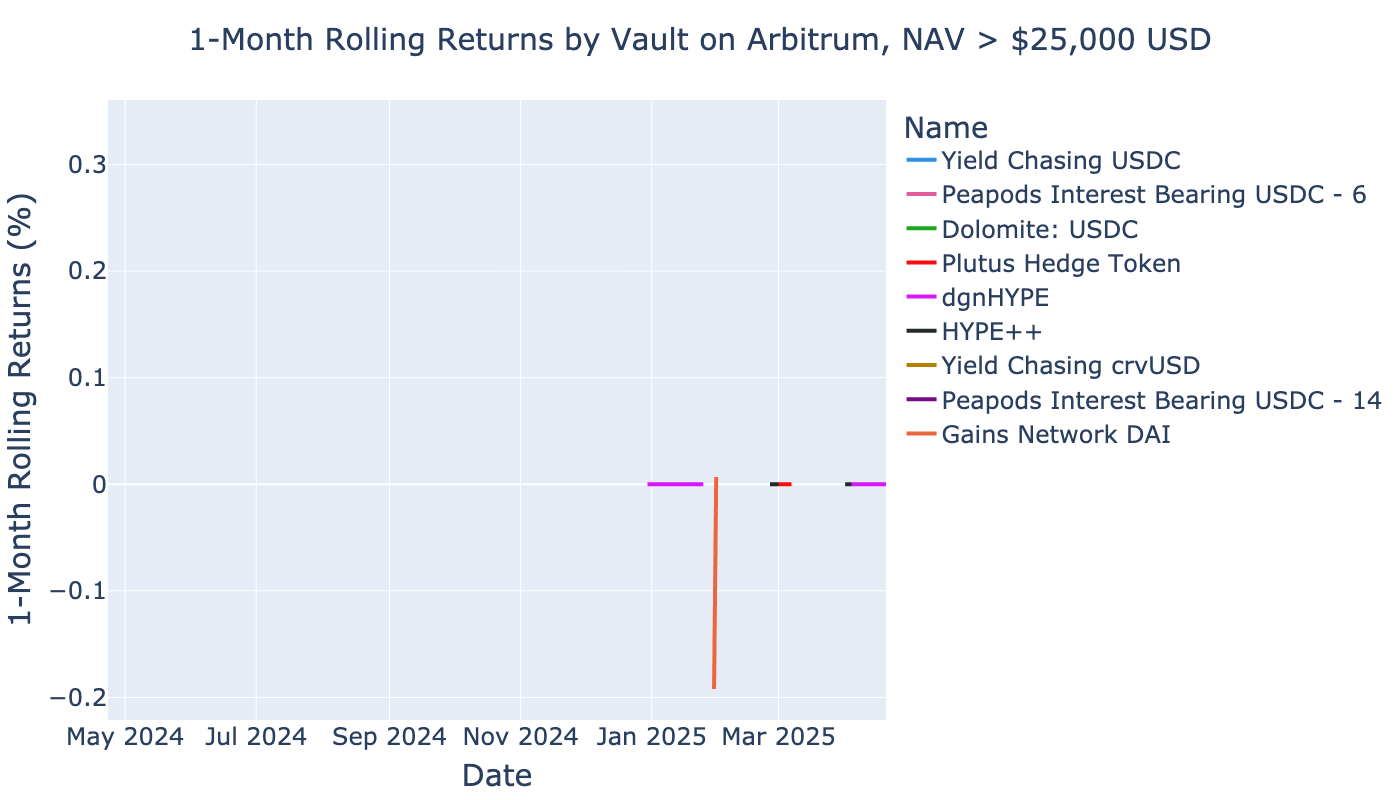

Displaying top 3 months performers on Ethereum


cagr  lifetime_return  \
name                                                                     
USDC to yvUSDS Farmer                            4.38             1.41   
IdleCDO BB Tranche - idle_cpPOR-USDC4626Adapter  0.79             2.23   
DAI to yvUSDS Farmer                             1.78             0.71   
Aave V3 USDS Lender                             23.22             4.34   
Morpho Steakhouse USDT Compounder                1.16             0.24   
Morpho Gauntlet USDT Prime Compounder            0.98             0.21   
cSuperior Quality Private Credit USDC            0.58             0.26   
Morpho Gauntlet DAI Core Compounder              0.40             0.12   
Peapods Interest Bearing USDC - 21               0.32             0.02   
Peapods Interest Bearing USDC - 1                0.27             0.05   

                                                 three_months_cagr  \
name                                                                 
USDC to yvUSDS Farmer                                         4.17   
IdleCDO BB Tranche - idle_cpPOR-USDC4626Adapter               3.09   
DAI to yvUSDS Farmer                                          1.67   
Aave V3 USDS Lender                                           1.40   
Morpho Steakhouse USDT Compounder                             1.14   
Morpho Gauntlet USDT Prime Compounder                         0.96   
cSuperior Quality Private Credit USDC                         0.45   
Morpho Gauntlet DAI Core Compounder                           0.38   
Peapods Interest Bearing USDC - 21                            0.32   
Peapods Interest Bearing USDC - 1                             0.27   

                                                     peak_nav  current_nav  \
name                                                                         
USDC to yvUSDS Farmer                            4,084,947.17 3,127,219.65   
IdleCDO BB Tranche - idle_cpPOR-USDC4626Adapter 10,548,140.35   327,797.72   
DAI to yvUSDS Farmer                             5,275,453.95 3,056,848.86   
Aave V3 USDS Lender                              3,869,616.39   147,937.22   
Morpho Steakhouse USDT Compounder                2,076,602.94   551,371.92   
Morpho Gauntlet USDT Prime Compounder            3,797,237.37   551,096.98   
cSuperior Quality Private Credit USDC              181,726.10   169,984.08   
Morpho Gauntlet DAI Core Compounder              1,290,621.64   242,673.29   
Peapods Interest Bearing USDC - 21                  75,101.75    74,870.59   
Peapods Interest Bearing USDC - 1                   50,378.46    27,075.27   

                                                 years  mgmt_fee  perf_fee  \
name                                                                         
USDC to yvUSDS Farmer                             0.52       NaN       NaN   
IdleCDO BB Tranche - idle_cpPOR-USDC4626Adapter   2.02       NaN       NaN   
DAI to yvUSDS Farmer                              0.52       NaN       NaN   
Aave V3 USDS Lender                               0.53       NaN       NaN   
Morpho Steakhouse USDT Compounder                 0.28       NaN       NaN   
Morpho Gauntlet USDT Prime Compounder             0.28       NaN       NaN   
cSuperior Quality Private Credit USDC             0.51       NaN       NaN   
Morpho Gauntlet DAI Core Compounder               0.34       NaN       NaN   
Peapods Interest Bearing USDC - 21                0.08       NaN       NaN   
Peapods Interest Bearing USDC - 1                 0.20       NaN       NaN   

                                                 event_count  \
name                                                           
USDC to yvUSDS Farmer                                 169.00   
IdleCDO BB Tranche - idle_cpPOR-USDC4626Adapter        31.00   
DAI to yvUSDS Farmer                                  178.00   
Aave V3 USDS Lender                                   264.00   
Morpho Steakhouse USDT Compounder                      55.00 

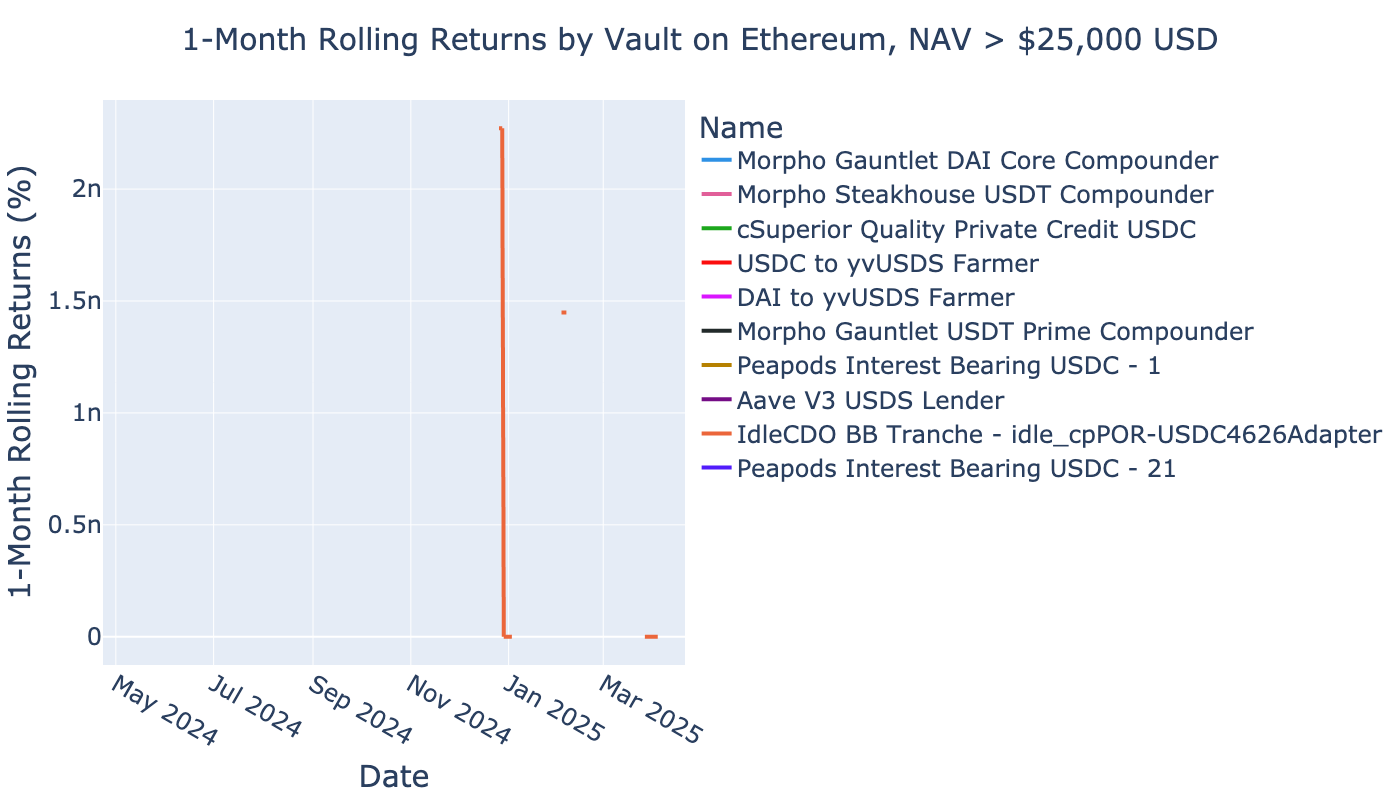

Displaying top 3 months performers on Base


cagr  lifetime_return  \
name                                                              
Vault                                     0.43             0.08   
Peapods Interest Bearing USDC - 42        0.32             0.05   
Peapods Interest Bearing USDC - 15        0.28             0.05   
Peapods Interest Bearing USDC - 67        0.24             0.02   
Peapods Interest Bearing USDC - 7         0.17             0.03   
Morpho Moonwell Flagship USDC Compounder  0.18             0.06   
Clearstar OpenEden USDC                   0.09             0.01   
EVK Vault eUSDC-3                         0.08             0.02   
Smokehouse USDC                           0.08             0.01   
Apostro Resolv USR                        0.07             0.01   

                                          three_months_cagr     peak_nav  \
name                                                                       
Vault                                                  0.43 1,256,193.78   
Peapods Interest Bearing USDC - 42                     0.32    93,761.20   
Peapods Interest Bearing USDC - 15                     0.28    91,617.57   
Peapods Interest Bearing USDC - 67                     0.24   138,234.88   
Peapods Interest Bearing USDC - 7                      0.17    55,284.01   
Morpho Moonwell Flagship USDC Compounder               0.16    63,265.85   
Clearstar OpenEden USDC                                0.09 3,845,859.35   
EVK Vault eUSDC-3                                      0.08 2,866,163.20   
Smokehouse USDC                                        0.08 3,441,767.10   
Apostro Resolv USR                                     0.07 1,700,378.42   

                                          current_nav  years  mgmt_fee  \
name                                                                     
Vault                                    1,256,193.78   0.22       NaN   
Peapods Interest Bearing USDC - 42          30,430.00   0.18       NaN   
Peapods Interest Bearing USDC - 15          64,029.04   0.20       NaN   
Peapods Interest Bearing USDC - 67         137,588.11   0.07       NaN   
Peapods Interest Bearing USDC - 7           40,709.70   0.22       NaN   
Morpho Moonwell Flagship USDC Compounder    63,265.85   0.33       NaN   
Clearstar OpenEden USDC                  2,125,722.37   0.11      0.00   
EVK Vault eUSDC-3                          911,548.74   0.25       NaN   
Smokehouse USDC                          2,241,101.13   0.11      0.00   
Apostro Resolv USR                       1,175,836.69   0.16      0.00   

                                          perf_fee  event_count  \
name                                                              
Vault                                          NaN       646.00   
Peapods Interest Bearing USDC - 42             NaN     1,800.00   
Peapods Interest Bearing USDC - 15             NaN     7,473.00   
Peapods Interest Bearing USDC - 67             NaN       993.00   
Peapods Interest Bearing USDC - 7              NaN       295.00   
Morpho Moonwell Flagship USDC Compounder       NaN       175.00   
Clearstar OpenEden USDC                       0.15     1,939.00   
EVK Vault eUSDC-3                              NaN     6,642.00   
Smokehouse USDC                               0.10     2,448.00   
Apostro Resolv USR                            0.10     1,337.00   

                                                    protocol  \
name                                                           
Vault                                     <unknown ERC-4626>   
Peapods Interest Bearing USDC - 42                   Peapods   
Peapods Interest Bearing USDC - 15                   Peapods   
Peapods Interest Bearing USDC - 67                   Peapods   
Peapods Interest Bearing USDC - 7                    Peapods   
Morpho Moonwell Flagship USDC Compounder  <unknown ERC-4626>   
Clearstar OpenEden USDC                               Morpho   
EVK Vault eUSDC-3                            Euler Vau

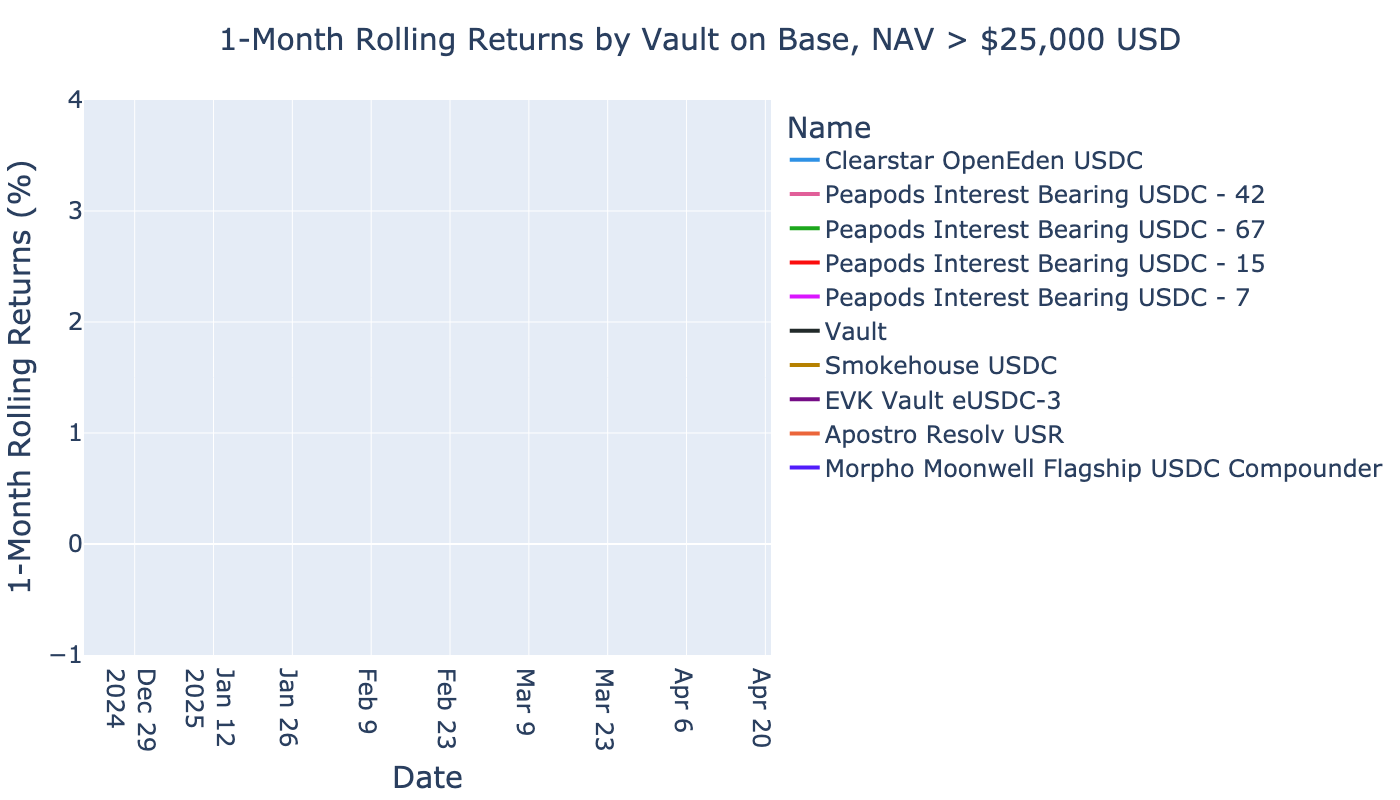

Displaying top 3 months performers on Avalanche


cagr  lifetime_return  three_months_cagr  \
name                                                                    
Staked avUSD                 0.09             0.04               0.08   
EVK Vault eAUSD-2            0.06             0.00               0.06   
Staked deUSD                 0.04             0.01               0.04   
Wrapped Aave Avalanche AUSD  0.04             0.00               0.04   
EVK Vault eUSDt-3            0.04             0.00               0.04   
EVK Vault eUSDC-2            0.03             0.00               0.03   
Wrapped Aave Avalanche USDC  0.02             0.00               0.02   
Wrapped Aave Avalanche USDT  0.02             0.00               0.02   
Static Aave Avalanche USDC   0.05             0.03               0.01   
HiYield Treasury Bill Vault  0.04             0.05               0.01   

                                 peak_nav   current_nav  years  mgmt_fee  \
name                                                                       
Staked avUSD                29,939,720.37 29,939,720.37   0.42       NaN   
EVK Vault eAUSD-2           49,928,735.09 49,466,261.96   0.03       NaN   
Staked deUSD                   199,274.64    199,274.64   0.25       NaN   
Wrapped Aave Avalanche AUSD  2,539,871.28  2,420,599.41   0.03       NaN   
EVK Vault eUSDt-3           14,999,963.48 14,999,963.48   0.03       NaN   
EVK Vault eUSDC-2           53,202,828.80 53,202,828.80   0.05       NaN   
Wrapped Aave Avalanche USDC  1,589,839.11  1,589,839.11   0.03       NaN   
Wrapped Aave Avalanche USDT  1,587,874.48  1,587,874.48   0.03       NaN   
Static Aave Avalanche USDC     382,038.28    163,664.78   0.68       NaN   
HiYield Treasury Bill Vault  2,671,619.07  2,307,956.90   1.20       NaN   

                             perf_fee  event_count            protocol  \
name                                                                     
Staked avUSD                      NaN       962.00  <unknown ERC-4626>   
EVK Vault eAUSD-2                 NaN     1,655.00     Euler Vault Kit   
Staked deUSD                      NaN       354.00  <unknown ERC-4626>   
Wrapped Aave Avalanche AUSD       NaN       463.00  <unknown ERC-4626>   
EVK Vault eUSDt-3                 NaN       847.00     Euler Vault Kit   
EVK Vault eUSDC-2                 NaN     1,906.00     Euler Vault Kit   
Wrapped Aave Avalanche USDC       NaN     1,580.00  <unknown ERC-4626>   
Wrapped Aave Avalanche USDT       NaN       587.00  <unknown ERC-4626>   
Static Aave Avalanche USDC        NaN     2,836.00           Superform   
HiYield Treasury Bill Vault       NaN       178.00  <unknown ERC-4626>   

                                                                           id  \
name                                                                            
Staked avUSD                 43114-0x06d47f3fb376649c3a9dafe069b3d6e35572219e   
EVK Vault eAUSD-2            43114-0x2137568666f12fc5a026f5430ae7194f1c1362ab   
Staked deUSD                 43114-0x68088c91446c7bea49ea7dbd3b96ce62b272dc96   
Wrapped Aave Avalanche AUSD  43114-0x45cf39eeb437fa95bb9b52c0105254a6bd25d01e   
EVK Vault eUSDt-3            43114-0xa446938b0204aa4055cdfed68ddf0e0d1bab3e9e   
EVK Vault eUSDC-2            43114-0x39de0f00189306062d79edec6dca5bb6bfd108f9   
Wrapped Aave Avalanche USDC  43114-0xe1bfc96d95badcb10ff013cb0c9c6c737ca07009   
Wrapped Aave Avalanche USDT  43114-0x59933c571d200dc6a7fd1cda22495db442082e34   
Static Aave Avalanche USDC   43114-0xc509ab7bb4edbf193b82264d499a7fc526cd01f4   
HiYield Treasury Bill Vault  43114-0x8475509d391e6ee5a8b7133221ce17019d307b3e   

                             three_months_returns start_date   end_date  
name                                                                     
Staked avUSD                                 0.03 2025-01-23 2025-04-21  
EVK Vault eAUSD-2                            0.00 2025-04-10 2025-04-21  
Staked deUSD                                 0.01 2025-01-23 2025-04-21  
Wrapped

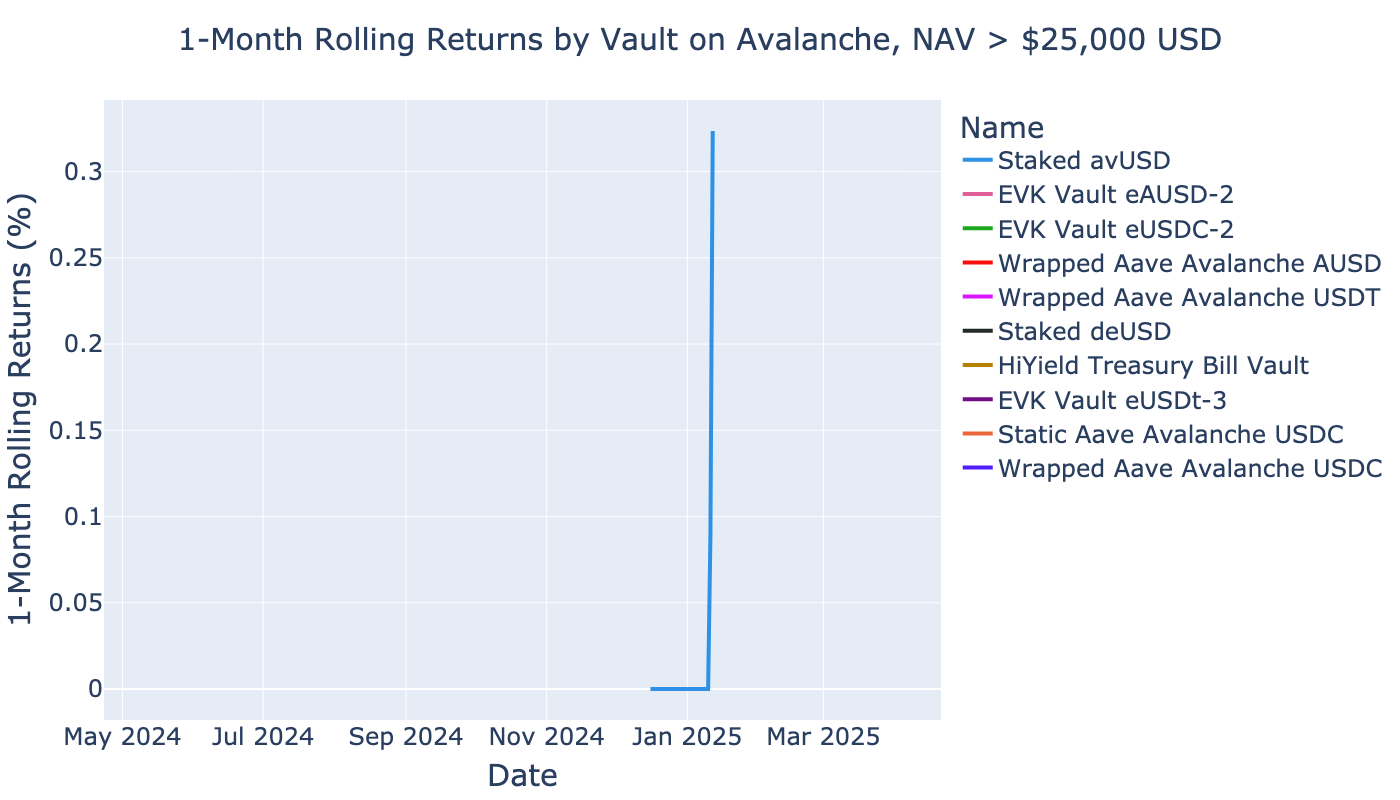

Displaying top 3 months performers on Polygon


cagr  lifetime_return  three_months_cagr  \
name                                                                        
Gains Network USDC               0.77             1.05               0.20   
Morpho Compound USDC Compounder  0.07             0.00               0.07   
Savings GYD                      0.14             0.06               0.06   
Gains Network DAI                0.26             0.72               0.05   
Ensuro MSV V2                    0.05             0.02               0.04   
Fluid USD Coin                   0.02             0.00               0.02   
Fluid (PoS) Tether USD           0.01             0.00               0.01   
USDC-1 yVault                    0.10             0.09               0.01   
Cool Wallet AAVEv3 USDT          0.08             0.06               0.01   
USDT yVault-A                    0.13             0.19               0.01   

                                     peak_nav   current_nav  years  mgmt_fee  \
name                                                                           
Gains Network USDC               1,040,536.58    691,187.19   1.25       NaN   
Morpho Compound USDC Compounder    231,512.28    231,512.28   0.06       NaN   
Savings GYD                         82,352.29     61,419.43   0.45       NaN   
Gains Network DAI               16,593,555.19    927,674.76   2.34       NaN   
Ensuro MSV V2                    1,329,197.99  1,329,197.99   0.30       NaN   
Fluid USD Coin                  15,213,384.60 14,721,929.29   0.12       NaN   
Fluid (PoS) Tether USD          14,164,985.46 13,079,106.45   0.12       NaN   
USDC-1 yVault                    6,774,871.16    227,020.04   0.95       NaN   
Cool Wallet AAVEv3 USDT          1,549,091.26  1,406,057.39   0.77       NaN   
USDT yVault-A                    5,036,997.57    441,268.38   1.37       NaN   

                                 perf_fee  event_count            protocol  \
name                                                                         
Gains Network USDC                    NaN       678.00  <unknown ERC-4626>   
Morpho Compound USDC Compounder       NaN       103.00  <unknown ERC-4626>   
Savings GYD                           NaN        58.00  <unknown ERC-4626>   
Gains Network DAI                     NaN    21,651.00  <unknown ERC-4626>   
Ensuro MSV V2                         NaN     1,047.00  <unknown ERC-4626>   
Fluid USD Coin                        NaN     1,216.00               Fluid   
Fluid (PoS) Tether USD                NaN     2,812.00               Fluid   
USDC-1 yVault                         NaN    19,521.00            Yearn v3   
Cool Wallet AAVEv3 USDT               NaN       638.00      Kiln Metavault   
USDT yVault-A                         NaN   458,256.00            Yearn v3   

                                                                             id  \
name                                                                              
Gains Network USDC               137-0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81   
Morpho Compound USDC Compounder  137-0x6e9ac188dbcc14632a253aa9ce2783cd712ab3ca   
Savings GYD                      137-0xea50f402653c41cadbafd1f788341db7b7f37816   
Gains Network DAI                137-0x91993f2101cc758d0deb7279d41e880f7defe827   
Ensuro MSV V2                    137-0x14f6dfee761455247c6bf2b2b052a1f6245dd6fb   
Fluid USD Coin                   137-0x571d456b578fdc34e26e6d636736ed7c0cdb9d89   
Fluid (PoS) Tether USD           137-0x6f5e34eff43d9ab7c977512509c53840b5efba85   
USDC-1 yVault                    137-0x34b9421fe3d52191b64bc32ec1ab764dcbcdbf5e   
Cool Wallet AAVEv3 USDT          137-0x03441c89e7b751bb570f9dc8c92702b127c52c51   
USDT yVault-A                    137-0xbb287e6017d3deb0e2e65061e8684eab21060123   

                                 three_months_returns start_date   end_date  
name                                                                         
Gains Network USDC                               0.25 202

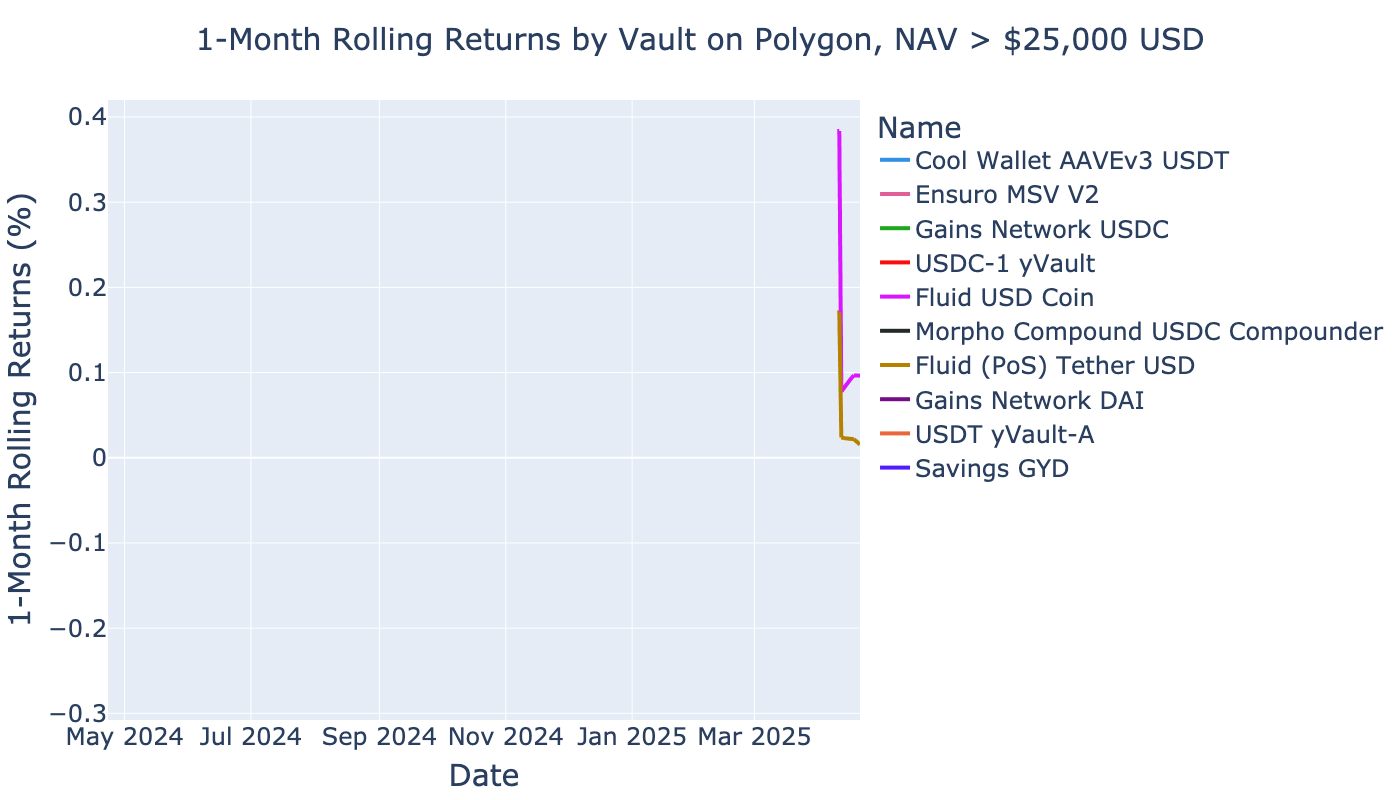

Displaying top 3 months performers on ZKsync


cagr  lifetime_return  three_months_cagr  \
name                                                                      
FARM_USDC.e                    6.85             0.68               6.87   
FARM_USDC.e                    0.39             0.31               0.13   
Wrapped Mountain Protocol USD  0.17             0.08               0.02   
hsUSDC                         0.12             0.25               0.02   

                                  peak_nav  current_nav  years  mgmt_fee  \
name                                                                       
FARM_USDC.e                      94,421.99    32,601.88   0.25       NaN   
FARM_USDC.e                      62,224.41    60,815.60   0.82       NaN   
Wrapped Mountain Protocol USD 6,853,574.48   219,601.37   0.46       NaN   
hsUSDC                        3,991,529.01   736,998.15   1.92       NaN   

                               perf_fee  event_count            protocol  \
name                                                                       
FARM_USDC.e                         NaN        33.00     Harvest Finance   
FARM_USDC.e                         NaN        27.00     Harvest Finance   
Wrapped Mountain Protocol USD       NaN       773.00  <unknown ERC-4626>   
hsUSDC                              NaN    48,708.00  <unknown ERC-4626>   

                                                                           id  \
name                                                                            
FARM_USDC.e                    324-0x6047987b668804506133887db55eeb0a709c73c4   
FARM_USDC.e                    324-0x1b51ea0e4edf4fac001d3cd55d3fafc1d1f02f26   
Wrapped Mountain Protocol USD  324-0xa900cbe7739c96d2b153a273953620a701d5442b   
hsUSDC                         324-0xaf08a9d918f16332f22cf8dc9abe9d9e14ddcbc2   

                               three_months_returns start_date   end_date  
name                                                                       
FARM_USDC.e                                    0.68 2025-01-23 2025-04-20  
FARM_USDC.e                                    0.11 2025-01-23 2025-04-20  
Wrapped Mountain Protocol USD                  0.01 2025-01-23 2025-04-20  
hsUSDC                                         0.04 2025-01-23 2025-04-20

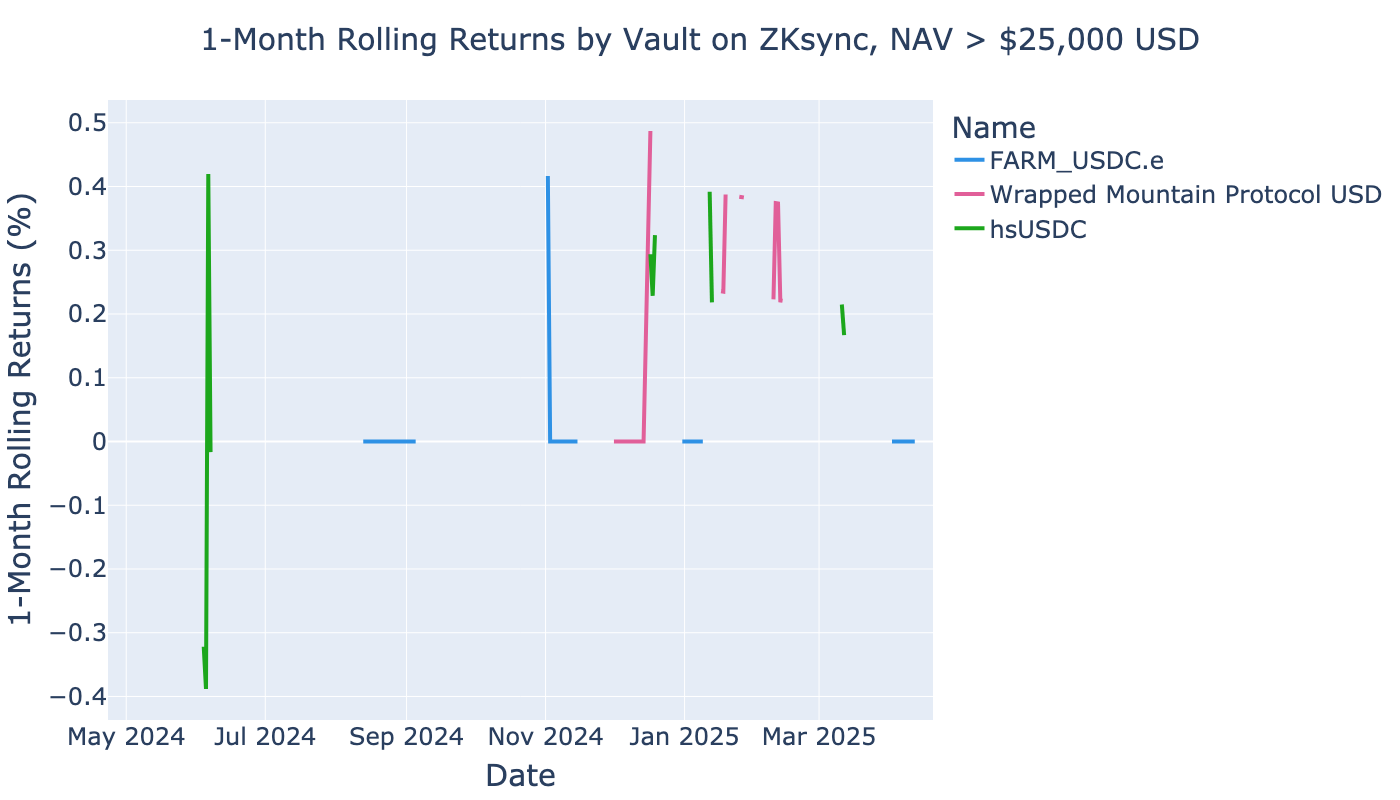

Displaying top 3 months performers on Gnosis


cagr  lifetime_return  three_months_cagr  \
name                                                                       
Savings GYD                     0.10             0.04               0.06   
Savings xDAI                    0.11             0.17               0.01   
Static Aave Gnosis USDCe        0.03             0.02               0.01   
Staked EURA                     0.05             0.07               0.01   
Prize WXDAI - DAI Savings Rate -0.00            -0.00              -0.00   

                                    peak_nav   current_nav  years  mgmt_fee  \
name                                                                          
Savings GYD                       297,345.83    284,303.10   0.46       NaN   
Savings xDAI                   87,049,009.16 71,886,249.92   1.56       NaN   
Static Aave Gnosis USDCe          591,994.90    318,391.67   0.62       NaN   
Staked EURA                       720,595.16    614,433.40   1.63       NaN   
Prize WXDAI - DAI Savings Rate  1,541,649.15  1,176,050.72   0.58       NaN   

                                perf_fee  event_count            protocol  \
name                                                                        
Savings GYD                          NaN       142.00  <unknown ERC-4626>   
Savings xDAI                         NaN   562,263.00  <unknown ERC-4626>   
Static Aave Gnosis USDCe             NaN     2,211.00           Superform   
Staked EURA                          NaN     3,602.00  <unknown ERC-4626>   
Prize WXDAI - DAI Savings Rate       NaN     1,638.00  <unknown ERC-4626>   

                                                                            id  \
name                                                                             
Savings GYD                     100-0xea50f402653c41cadbafd1f788341db7b7f37816   
Savings xDAI                    100-0xaf204776c7245bf4147c2612bf6e5972ee483701   
Static Aave Gnosis USDCe        100-0xf0e7ec247b918311afa054e0aedb99d74c31b809   
Staked EURA                     100-0x004626a008b1acdc4c74ab51644093b155e59a23   
Prize WXDAI - DAI Savings Rate  100-0xbb7e99abccce01589ad464ff698ad139b0705d90   

                                three_months_returns start_date   end_date  
name                                                                        
Savings GYD                                     0.03 2025-01-23 2025-04-21  
Savings xDAI                                    0.02 2025-01-23 2025-04-21  
Static Aave Gnosis USDCe                        0.01 2025-01-23 2025-04-21  
Staked EURA                                     0.01 2025-01-23 2025-04-21  
Prize WXDAI - DAI Savings Rate                 -0.00 2025-01-23 2025-04-21

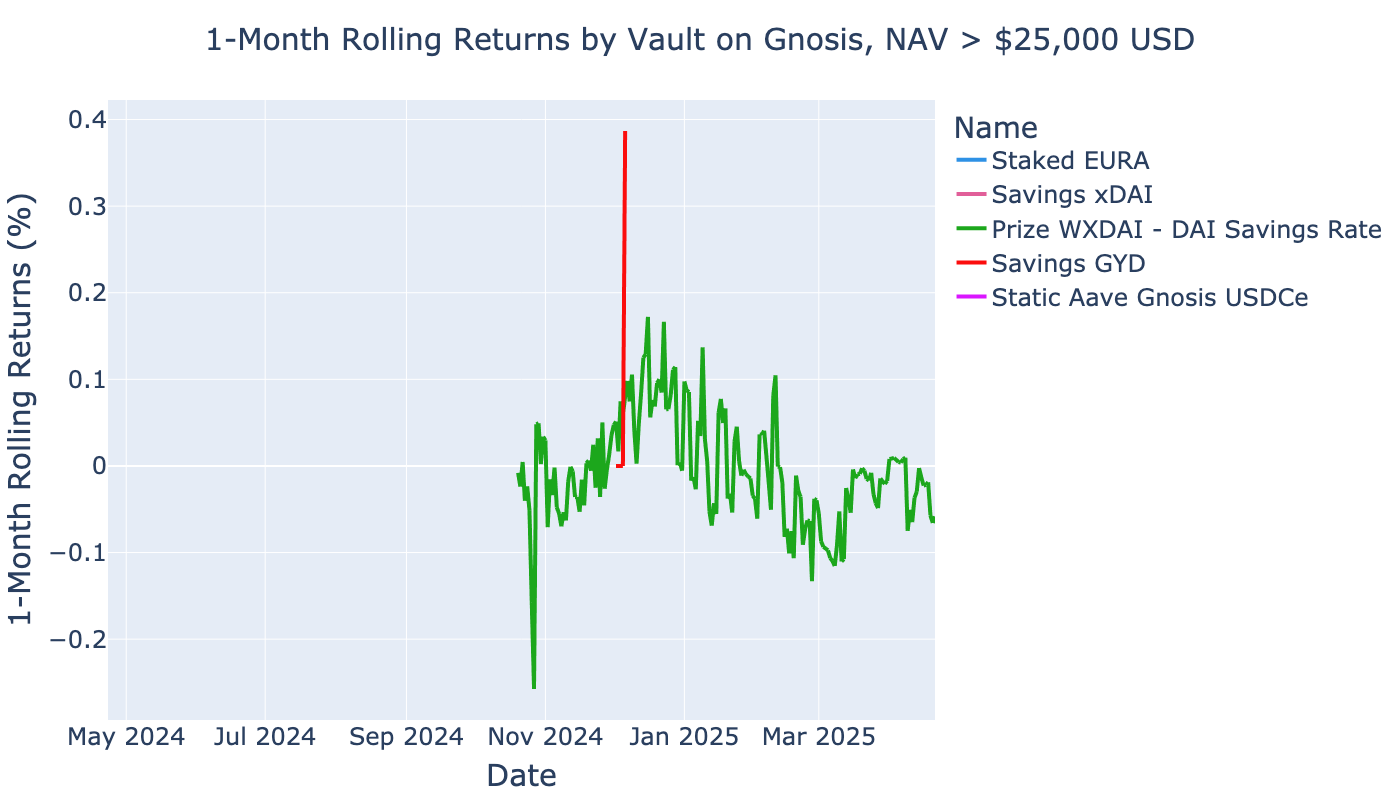

Displaying top 3 months performers on Optimism


cagr  lifetime_return  three_months_cagr  \
name                                                                      
40op-USDC-Vault                0.37             0.05               0.37   
Curve Vault for crvUSD         0.10             0.05               0.04   
PoolTogether USDC winETH      -0.68            -0.44               0.02   
ERC4626-Wrapped Aave v3 USDC   0.07             0.03               0.02   
Aave V3 DAI Lender             0.06             0.04               0.01   
Aave V3 USDC.e Lender          0.05             0.03               0.01   
Static Aave Optimism USDC      0.05             0.03               0.01   
Staked USDA                    0.09             0.11               0.01   
Wrapped Mountain Protocol USD  0.05             0.04               0.01   
exactly USDC.e                 0.07             0.15               0.01   

                                   peak_nav  current_nav  years  mgmt_fee  \
name                                                                        
40op-USDC-Vault                  251,170.04   247,902.39   0.15       NaN   
Curve Vault for crvUSD           104,984.32   104,984.32   0.48       NaN   
PoolTogether USDC winETH       3,144,851.97   417,566.37   0.51       NaN   
ERC4626-Wrapped Aave v3 USDC   3,144,851.97   417,566.37   0.51       NaN   
Aave V3 DAI Lender               114,228.08    25,227.67   0.69       NaN   
Aave V3 USDC.e Lender            445,783.08    44,892.15   0.69       NaN   
Static Aave Optimism USDC        161,092.80   158,000.24   0.68       NaN   
Staked USDA                    3,119,952.57   102,698.92   1.28       NaN   
Wrapped Mountain Protocol USD    977,346.56   320,582.05   0.90       NaN   
exactly USDC.e                84,340,403.48   306,320.95   2.13       NaN   

                               perf_fee  event_count            protocol  \
name                                                                       
40op-USDC-Vault                     NaN       147.00  <unknown ERC-4626>   
Curve Vault for crvUSD              NaN        60.00  <unknown ERC-4626>   
PoolTogether USDC winETH            NaN     2,867.00  <unknown ERC-4626>   
ERC4626-Wrapped Aave v3 USDC        NaN     2,905.00  <unknown ERC-4626>   
Aave V3 DAI Lender                  NaN       109.00  <unknown ERC-4626>   
Aave V3 USDC.e Lender               NaN        87.00  <unknown ERC-4626>   
Static Aave Optimism USDC           NaN     1,260.00           Superform   
Staked USDA                         NaN       777.00  <unknown ERC-4626>   
Wrapped Mountain Protocol USD       NaN    39,411.00  <unknown ERC-4626>   
exactly USDC.e                      NaN    37,692.00  <unknown ERC-4626>   

                                                                          id  \
name                                                                           
40op-USDC-Vault                10-0x08dcdbf7bade91ccd42cb2a4ea8e5d199d285957   
Curve Vault for crvUSD         10-0x05577790318929624b4613f5a7e3b73ab40e38de   
PoolTogether USDC winETH       10-0x11271bf9855b679bc484a0c80a69d8cc72fcef89   
ERC4626-Wrapped Aave v3 USDC   10-0xe6d87294db6eccf91baeecef341be48ea004414a   
Aave V3 DAI Lender             10-0x91e6c36992380017aecc91b0c21b0fbf4bb4fdd6   
Aave V3 USDC.e Lender          10-0x81bdd5e8fbde5a85a2d38761d03d2307fe69a329   
Static Aave Optimism USDC      10-0x9f281eb58fd98ad98ede0fc4c553ad4d73e7ca2c   
Staked USDA                    10-0x0022228a2cc5e7ef0274a7baa600d44da5ab5776   
Wrapped Mountain Protocol USD  10-0x57f5e098cad7a3d1eed53991d4d66c45c9af7812   
exactly USDC.e                 10-0x81c9a7b55a4df39a9b7b5f781ec0e53539694873   

                               three_months_returns start_date   end_date  
name                                                                       
40op-USDC-Vault                                0.05 2025-02-24 2025-04-21  
Curve Vault for crvUSD                         0.02 2025-01-23 2025-04-21  
PoolTogether USDC winETH   

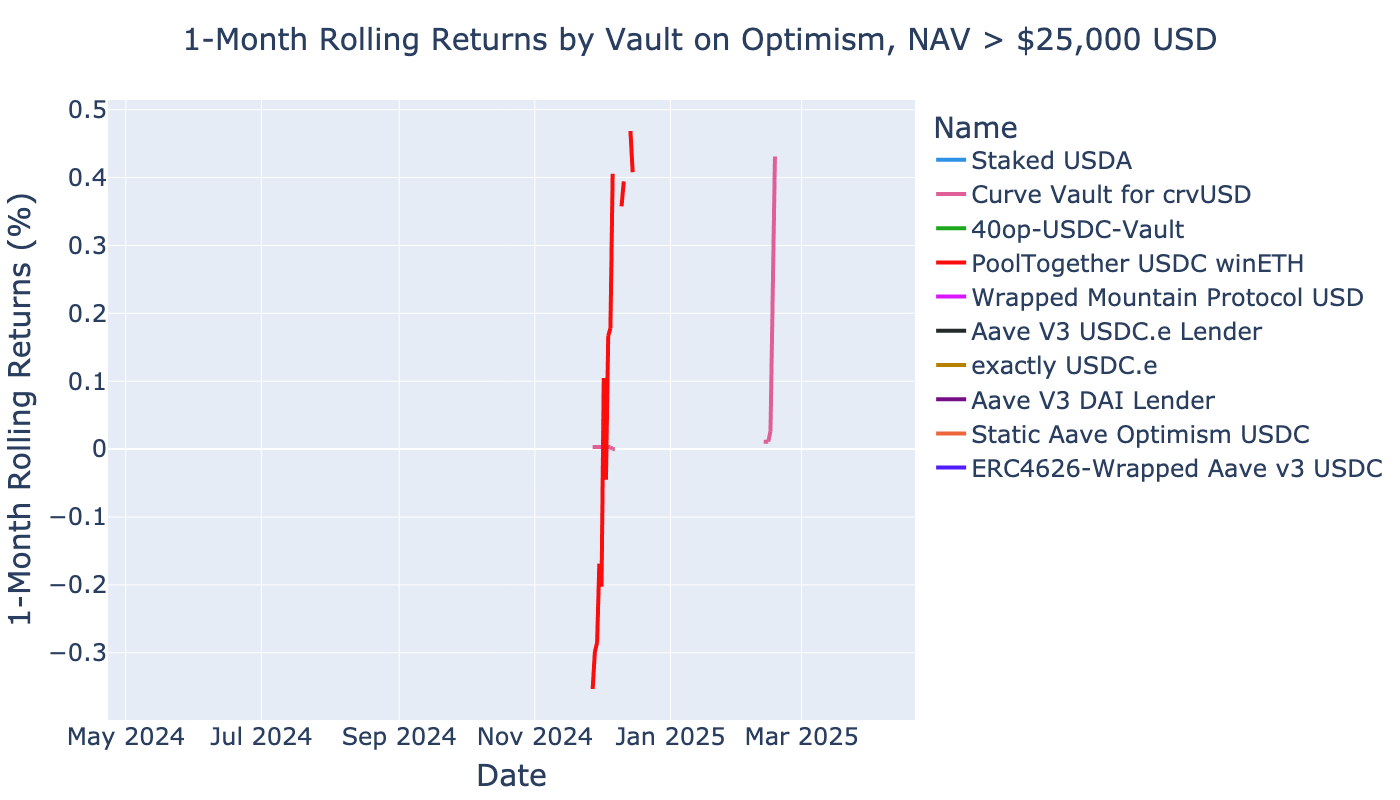

Displaying top 3 months performers on Binance


cagr  lifetime_return  three_months_cagr       peak_nav  \
name                                                                         
kBOX               0.46             0.11               0.46   6,119,183.47   
kREX               0.12             0.04               0.09   3,288,200.50   
EVK Vault eUSDT-2  0.05             0.00               0.05      25,455.00   
EVK Vault eUSDC-3  0.04             0.00               0.04     911,559.74   
EVK Vault eUSDT-3  0.03             0.00               0.03   1,614,865.28   
EVK Vault eYUSD-2  0.03             0.00               0.03   1,401,865.45   
EVK Vault eUSDT-4  0.03             0.00               0.03     897,536.90   
Saving USX         0.10             0.08               0.02     240,849.03   
EVK Vault eUSDT-5  0.02             0.00               0.02   4,501,379.81   
Staked USDX        0.07             0.08               0.01 199,844,736.55   

                     current_nav  years  mgmt_fee  perf_fee  event_count  \
name                                                                       
kBOX                5,873,845.01   0.27       NaN       NaN        50.00   
kREX                3,197,713.03   0.31       NaN       NaN        31.00   
EVK Vault eUSDT-2      25,455.00   0.01       NaN       NaN        33.00   
EVK Vault eUSDC-3     736,720.38   0.01       NaN       NaN       112.00   
EVK Vault eUSDT-3   1,469,603.08   0.01       NaN       NaN       189.00   
EVK Vault eYUSD-2   1,401,865.45   0.01       NaN       NaN        84.00   
EVK Vault eUSDT-4     897,536.90   0.01       NaN       NaN        98.00   
Saving USX            106,923.21   0.81       NaN       NaN        85.00   
EVK Vault eUSDT-5   4,501,379.81   0.01       NaN       NaN        58.00   
Staked USDX       199,844,736.55   1.09       NaN       NaN     5,532.00   

                             protocol  \
name                                    
kBOX               <unknown ERC-4626>   
kREX               <unknown ERC-4626>   
EVK Vault eUSDT-2     Euler Vault Kit   
EVK Vault eUSDC-3     Euler Vault Kit   
EVK Vault eUSDT-3     Euler Vault Kit   
EVK Vault eYUSD-2     Euler Vault Kit   
EVK Vault eUSDT-4     Euler Vault Kit   
Saving USX         <unknown ERC-4626>   
EVK Vault eUSDT-5     Euler Vault Kit   
Staked USDX        <unknown ERC-4626>   

                                                              id  \
name                                                               
kBOX               56-0x6e7a6eb5feec64bf6401a744757aba89c5c7e813   
kREX               56-0xa40e085d0584eed39daaa077fcc4cd153ae9a5b0   
EVK Vault eUSDT-2  56-0x6078b5de9d10587cb466ecbbf55c95898afe99c2   
EVK Vault eUSDC-3  56-0xa9ca5c4bff689afcfb249ae81565422fa78f82b4   
EVK Vault eUSDT-3  56-0x5fd02479f938929f6b9fe1b7af6430cfd4afa6aa   
EVK Vault eYUSD-2  56-0xc4db46b082b415c16c54c91c5750df8e2f90ef36   
EVK Vault eUSDT-4  56-0x69a93dbab609266af96f05658b2e22d020de2e19   
Saving USX         56-0xbc404429558292ee2d769e57d57d6e74bbd2792d   
EVK Vault eUSDT-5  56-0xca522ecab584b5430adb946edee4224a63628362   
Staked USDX        56-0x7788a3538c5fc7f9c7c8a74eac4c898fc8d87d92   

                   three_months_returns start_date   end_date  
name                                                           
kBOX                               0.11 2025-01-23 2025-04-21  
kREX                               0.03 2025-01-23 2025-04-21  
EVK Vault eUSDT-2                  0.00 2025-04-17 2025-04-21  
EVK Vault eUSDC-3                  0.00 2025-04-16 2025-04-21  
EVK Vault eUSDT-3                  0.00 2025-04-16 2025-04-21  
EVK Vault eYUSD-2                  0.00 2025-04-19 2025-04-21  
EVK Vault eUSDT-4                  0.00 2025-04-18 2025-04-21  
Saving USX                         0.02 2025-01-23 2025-04-21  
EVK Vault eUSDT-5                  0.00 2025-04-16 2025-04-21  
Staked USDX                        0.01 2025-01-23 2025-04-21

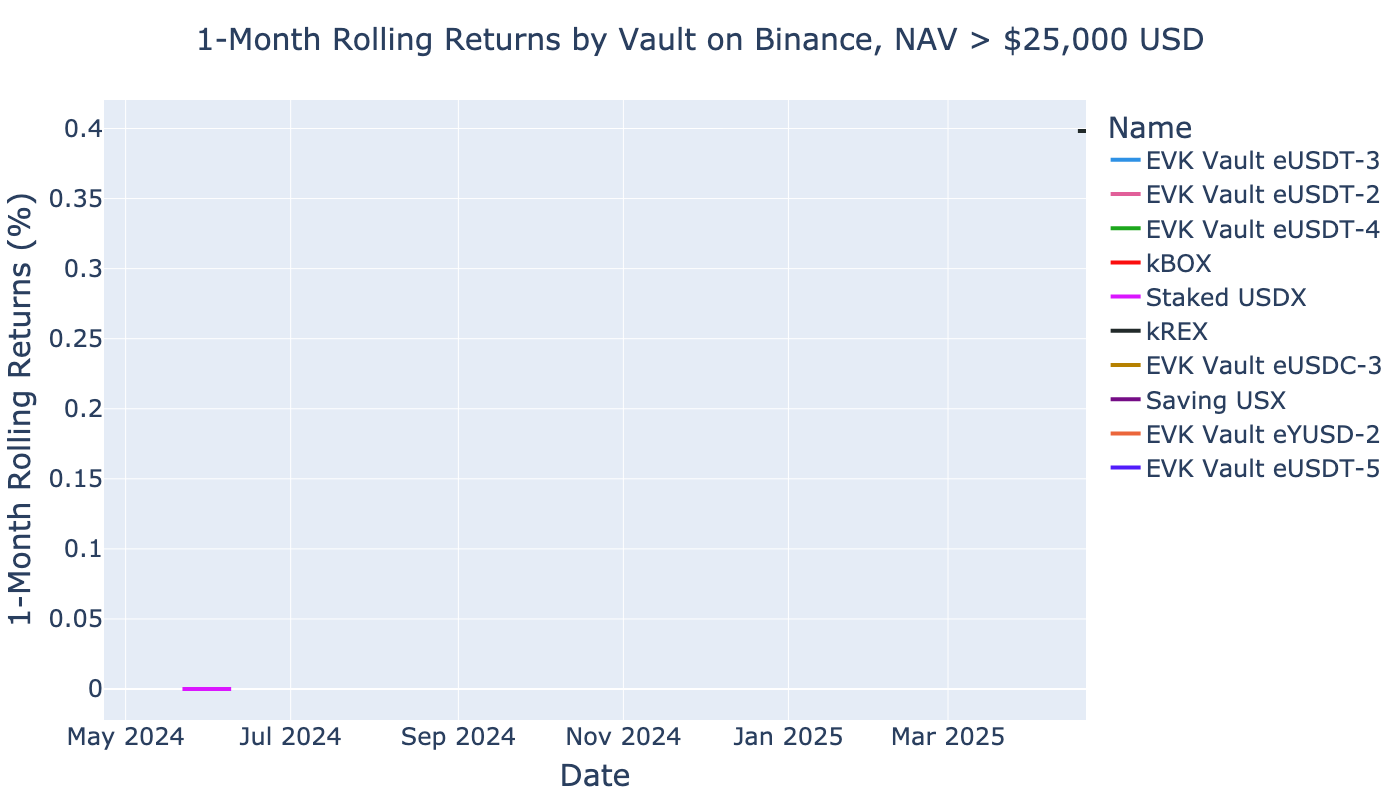

Displaying top 3 months performers on Blast


cagr  lifetime_return  three_months_cagr      peak_nav  \
name                                                                         
Wasabi USDB Vault   0.13             0.14               0.02 53,857,471.56   
Hyper USDB          0.09             0.09               0.02  5,122,939.24   
ybUSDB              0.09             0.10               0.01  1,740,737.67   
Vault Tranche USDB -0.05            -0.05               0.00 14,291,856.49   

                    current_nav  years  mgmt_fee  perf_fee  event_count  \
name                                                                      
Wasabi USDB Vault  1,501,490.41   1.13       NaN       NaN    92,847.00   
Hyper USDB           386,460.21   1.07       NaN       NaN    39,629.00   
ybUSDB                76,329.78   1.14       NaN       NaN    21,900.00   
Vault Tranche USDB    37,728.20   1.11       NaN       NaN    42,998.00   

                              protocol  \
name                                     
Wasabi USDB Vault   <unknown ERC-4626>   
Hyper USDB          <unknown ERC-4626>   
ybUSDB              <unknown ERC-4626>   
Vault Tranche USDB       Gains Network   

                                                                  id  \
name                                                                   
Wasabi USDB Vault   81457-0x4bed2a922654cacc2be974689619768fabf24855   
Hyper USDB          81457-0x390b781baf1e6db546cf4e3354b81446947838d2   
ybUSDB              81457-0xcd732d21c1b23a3f84bb386e9759b5b6a1bcbe39   
Vault Tranche USDB  81457-0xdb0c5d39c95a53ecda3fcf6f6c5c81c7a74910c7   

                    three_months_returns start_date   end_date  
name                                                            
Wasabi USDB Vault                   0.03 2025-01-23 2025-04-20  
Hyper USDB                          0.02 2025-01-23 2025-04-20  
ybUSDB                              0.02 2025-01-23 2025-04-20  
Vault Tranche USDB                  0.00 2025-01-23 2025-04-20

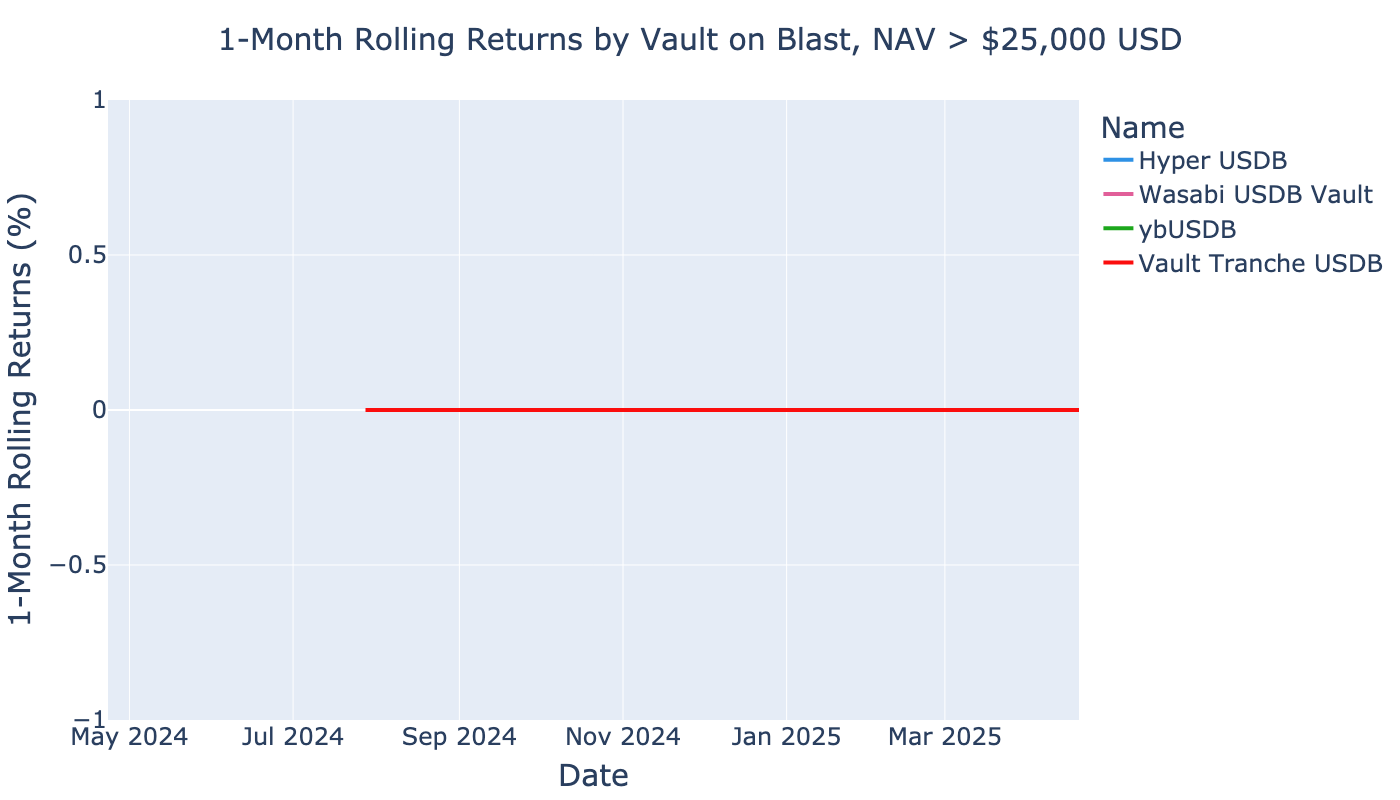

Displaying top 3 months performers on Mantle


Empty DataFrame
Columns: [cagr, lifetime_return, three_months_cagr, peak_nav, current_nav, years, mgmt_fee, perf_fee, event_count, protocol, id, three_months_returns, start_date, end_date]
Index: []

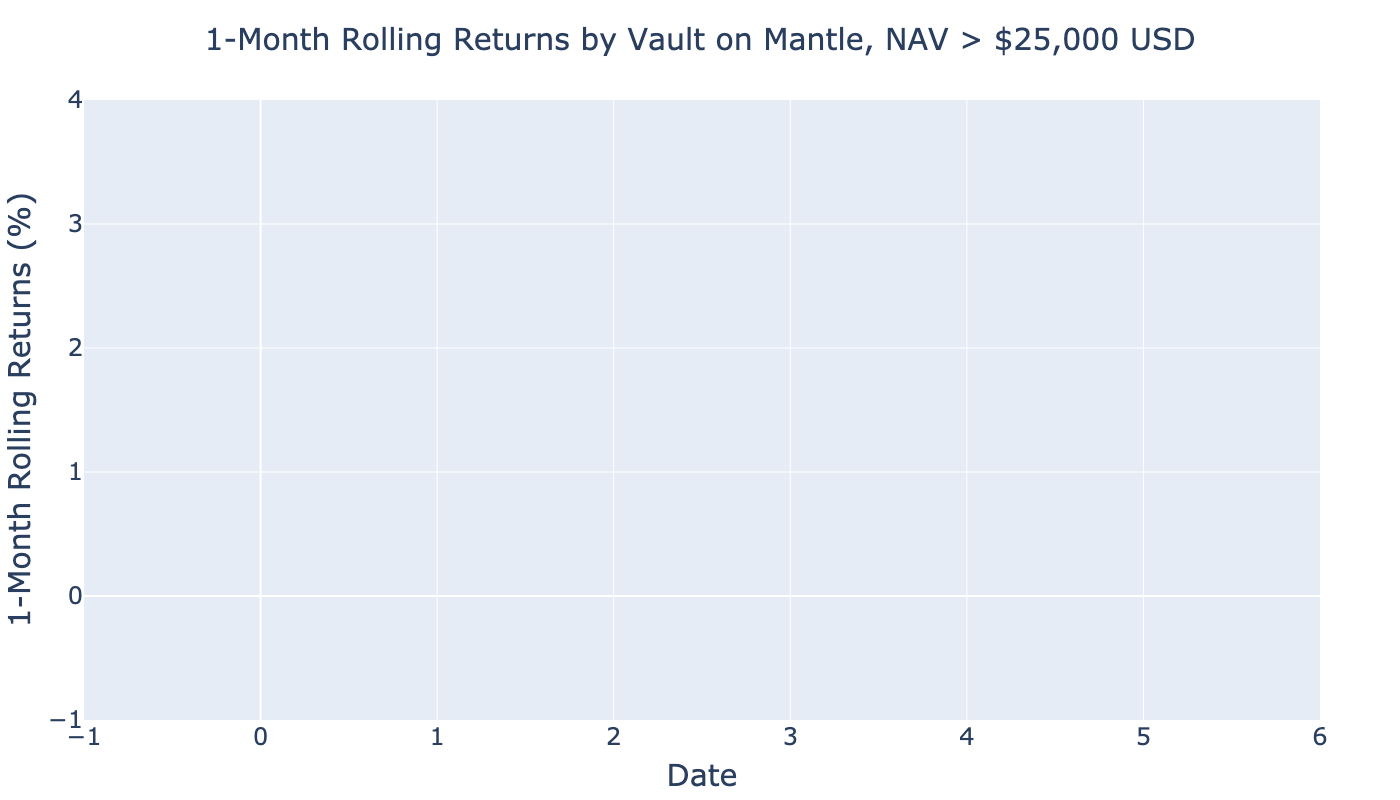

Displaying top 3 months performers on Berachain


cagr  lifetime_return  \
name                                                               
Lend USDC on Dahlia WBERA/USDC (68% LLTV)  0.13             0.02   
EVK Vault eUSDe-1                          0.08             0.00   
EVK Vault eUSDC.e-2                        0.07             0.01   
EVK Vault eUSDC.e-1                        0.05             0.00   
EVK Vault eUSDC.e-3                        0.05             0.00   
HyperBERA.USDC                             0.03             0.01   
EVK Vault eUSDC.e-4                        0.02             0.00   
Lend USDC on Dahlia sUSDe/USDC (91% LLTV)  0.00             0.00   
Bridged USDC (Stargate)Vault               0.00             0.00   
dgnBeraland                               -0.46            -0.12   

                                           three_months_cagr       peak_nav  \
name                                                                          
Lend USDC on Dahlia WBERA/USDC (68% LLTV)               0.13      53,677.82   
EVK Vault eUSDe-1                                       0.08     480,881.04   
EVK Vault eUSDC.e-2                                     0.07   5,398,319.00   
EVK Vault eUSDC.e-1                                     0.05   6,852,074.66   
EVK Vault eUSDC.e-3                                     0.05   5,472,974.66   
HyperBERA.USDC                                          0.03  10,000,000.00   
EVK Vault eUSDC.e-4                                     0.02      43,883.04   
Lend USDC on Dahlia sUSDe/USDC (91% LLTV)               0.00     654,847.27   
Bridged USDC (Stargate)Vault                            0.00 729,897,216.31   
dgnBeraland                                            -0.46     690,010.00   

                                             current_nav  years  mgmt_fee  \
name                                                                        
Lend USDC on Dahlia WBERA/USDC (68% LLTV)      37,820.27   0.20       NaN   
EVK Vault eUSDe-1                              34,703.69   0.06       NaN   
EVK Vault eUSDC.e-2                           717,046.57   0.09       NaN   
EVK Vault eUSDC.e-1                           756,398.95   0.09       NaN   
EVK Vault eUSDC.e-3                         3,840,484.81   0.09       NaN   
HyperBERA.USDC                              2,525,230.41   0.20       NaN   
EVK Vault eUSDC.e-4                            43,883.04   0.05       NaN   
Lend USDC on Dahlia sUSDe/USDC (91% LLTV)     654,733.71   0.20       NaN   
Bridged USDC (Stargate)Vault              189,693,686.78   0.23       NaN   
dgnBeraland                                   390,864.04   0.21       NaN   

                                           perf_fee  event_count  \
name                                                               
Lend USDC on Dahlia WBERA/USDC (68% LLTV)       NaN        90.00   
EVK Vault eUSDe-1                               NaN       387.00   
EVK Vault eUSDC.e-2                             NaN     1,260.00   
EVK Vault eUSDC.e-1                             NaN     1,518.00   
EVK Vault eUSDC.e-3                             NaN       771.00   
HyperBERA.USDC                                  NaN       743.00   
EVK Vault eUSDC.e-4                             NaN       270.00   
Lend USDC on Dahlia sUSDe/USDC (91% LLTV)       NaN        31.00   
Bridged USDC (Stargate)Vault                    NaN   171,993.00   
dgnBeraland                                     NaN       109.00   

                                                     protocol  \
name                                                            
Lend USDC on Dahlia WBERA/USDC (68% LLTV)  <unknown ERC-4626>   
EVK Vault eUSDe-1                             Euler Vault Kit   
EVK Vault eUSDC.e-2                           Euler Vault Kit   
EVK Vault eUSDC.e-1                           Euler Vault Kit   
EVK Vault eUSDC.e-3                           Euler Vault Kit   
HyperBERA.USDC                             <unknown ERC-4626>   
EVK Vault eUSDC

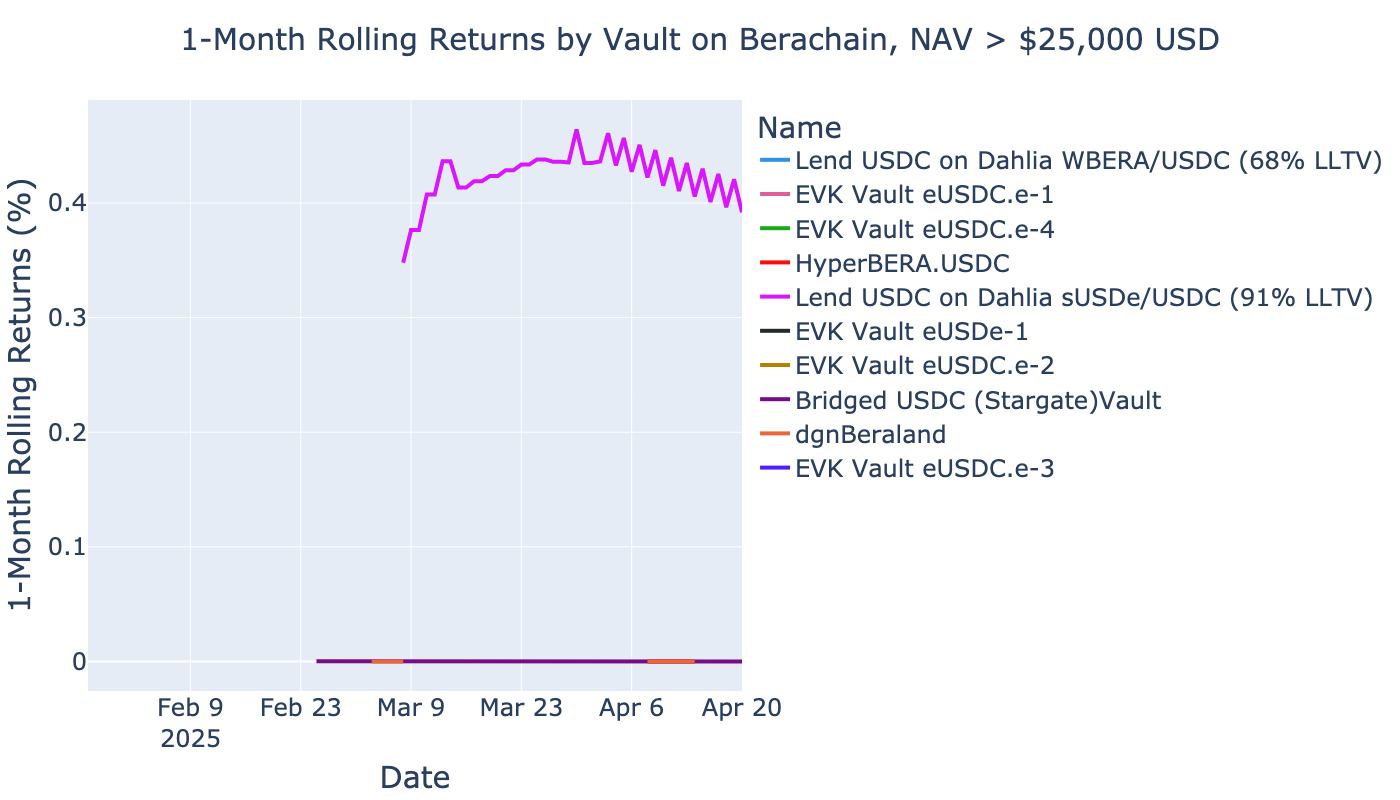

Displaying top 3 months performers on Mode


cagr  lifetime_return  three_months_cagr   peak_nav  \
name                                                                       
USDT Ironclad Vault  0.00             0.00               0.00 148,025.55   
USDC Ironclad Vault  0.00             0.00               0.00 599,423.34   

                     current_nav  years  mgmt_fee  perf_fee  event_count  \
name                                                                       
USDT Ironclad Vault   111,020.54   0.67       NaN       NaN        31.00   
USDC Ironclad Vault   337,647.27   0.67       NaN       NaN       183.00   

                               protocol  \
name                                      
USDT Ironclad Vault  <unknown ERC-4626>   
USDC Ironclad Vault  <unknown ERC-4626>   

                                                                   id  \
name                                                                    
USDT Ironclad Vault  34443-0xc9cfb5221ee50098bd8882727522301a62c7b021   
USDC Ironclad Vault  34443-0x882fd369341fc435ad5e54e91d1ebc23b1fc6d4c   

                     three_months_returns start_date   end_date  
name                                                             
USDT Ironclad Vault                  0.00 2025-01-23 2025-04-20  
USDC Ironclad Vault                  0.00 2025-01-23 2025-04-20

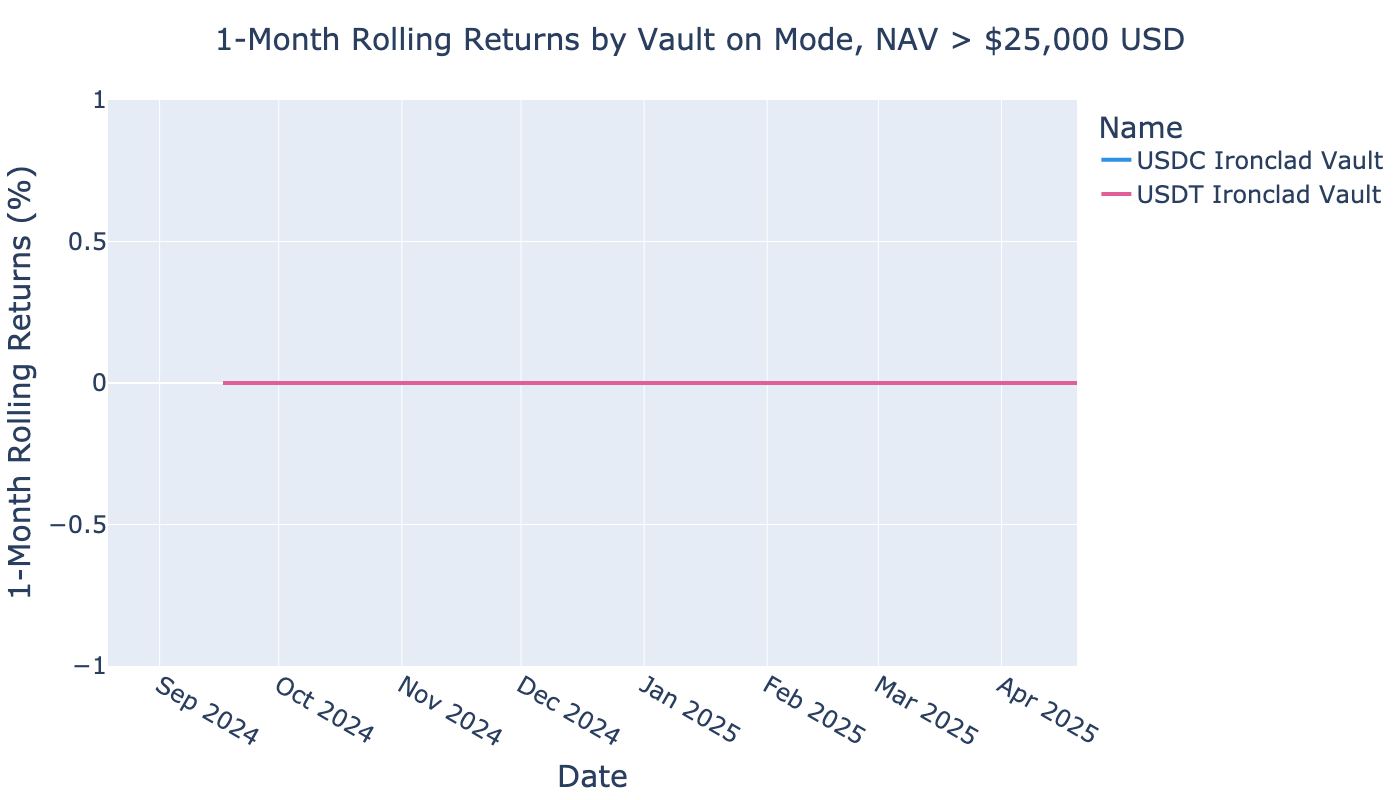

Displaying top 3 months performers on Celo


cagr  lifetime_return  three_months_cagr     peak_nav  \
name                                                                 
Staked EURA  0.04             0.06               0.01 3,191,244.29   

             current_nav  years  mgmt_fee  perf_fee  event_count  \
name                                                               
Staked EURA 3,191,244.29   1.63       NaN       NaN       223.00   

                       protocol  \
name                              
Staked EURA  <unknown ERC-4626>   

                                                           id  \
name                                                            
Staked EURA  42220-0x004626a008b1acdc4c74ab51644093b155e59a23   

             three_months_returns start_date   end_date  
name                                                     
Staked EURA                  0.01 2025-01-23 2025-04-21

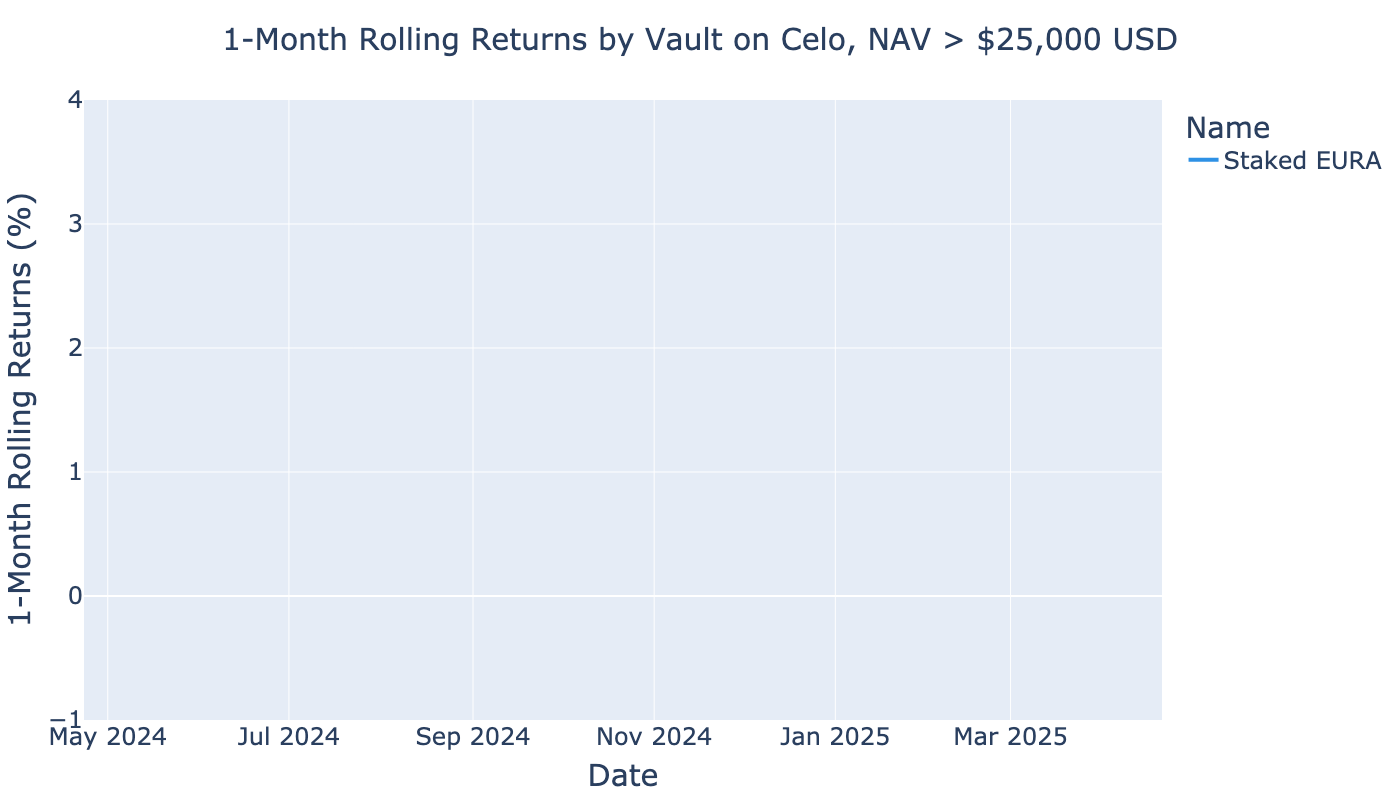

Displaying top 3 months performers on Soneium


cagr  lifetime_return  three_months_cagr     peak_nav  current_nav  \
name                                                                          
UB-USDC  0.00             0.00               0.00 1,466,682.67 1,189,033.07   

         years  mgmt_fee  perf_fee  event_count            protocol  \
name                                                                  
UB-USDC   0.27       NaN       NaN   229,071.00  <unknown ERC-4626>   

                                                      id  \
name                                                       
UB-USDC  1868-0xc675bb95d73ca7db2c09c3dc04daaa7944ccba41   

         three_months_returns start_date   end_date  
name                                                 
UB-USDC                  0.00 2025-01-23 2025-04-21

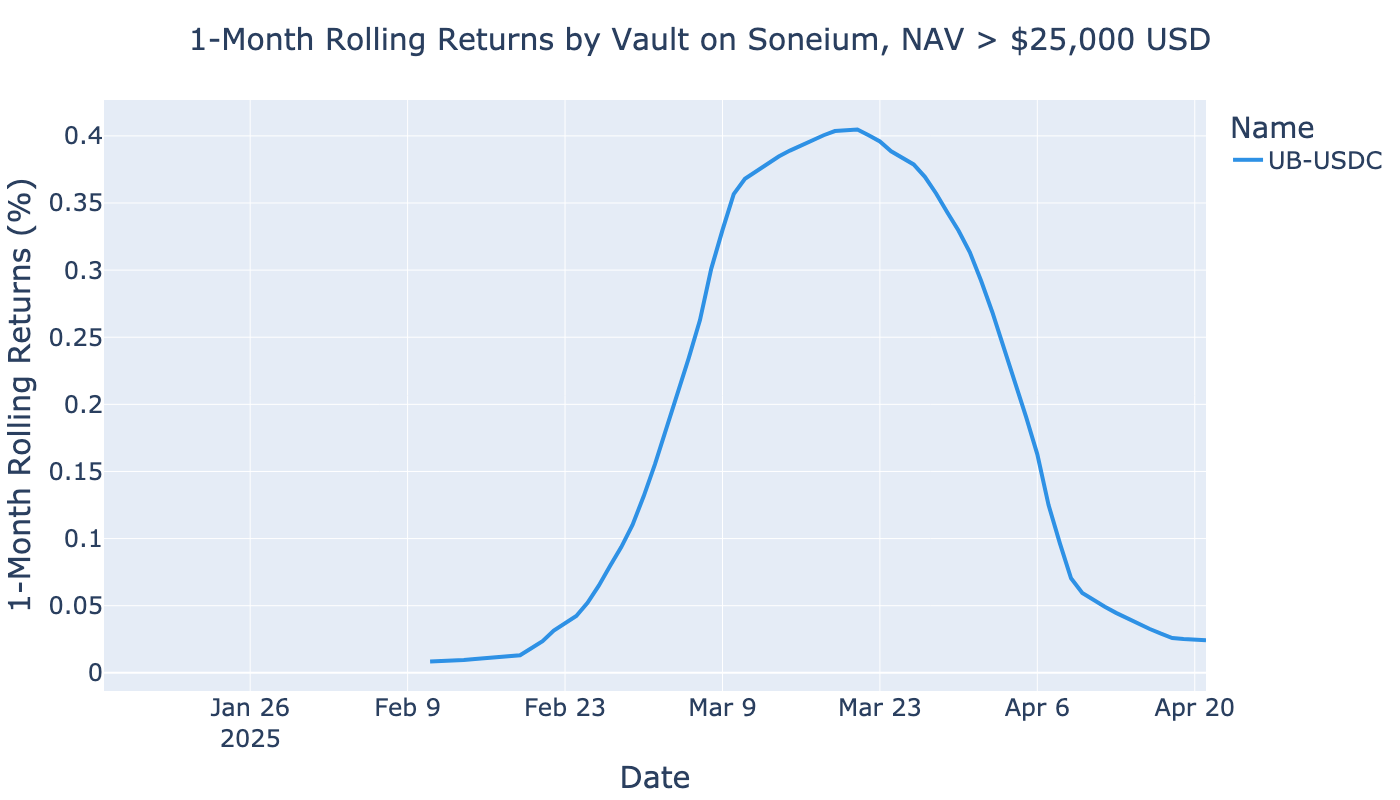

In [119]:
benchmark_count = 10
min_nav = 25_000

for chain_name in lifetime_data_df["chain"].unique():
    
    # chain_df = df[df["chain"] == chain_id]
    lifetime_data_filtered_df = lifetime_data_df[lifetime_data_df['chain'] == chain_name]
    
    lifetime_data_filtered_df = lifetime_data_filtered_df[lifetime_data_filtered_df["current_nav"] >= min_nav]
    lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='three_months_cagr', ascending=False)
 
    lifetime_data_filtered_slice_df = lifetime_data_filtered_df[0:benchmark_count]
    interesting_vaults = lifetime_data_filtered_slice_df["id"]
    df = calculate_rolling_returns(returns_df, interesting_vaults=interesting_vaults, cap=0.50)

    print(f"Displaying top 3 months performers on {chain_name}")
    lifetime_data_filtered_slice_df = lifetime_data_filtered_slice_df.drop(columns=["chain", "denomination"])
    display(lifetime_data_filtered_slice_df)
   
    fig = px.line(df, 
                  x='timestamp', 
                  y='rolling_1m_returns_annualized',
                  color='name',
                  title=f'1-Month Rolling Returns by Vault on {chain_name}, NAV > ${min_nav:,} USD',
                  labels={'rolling_1m_returns': '1-Month Rolling Returns (%)',
                         'timestamp': 'Date',
                         'name': 'Name'},
                  hover_data=['id'],
                  color_discrete_sequence=qualitative.Dark24,
                  )

    fig.update_layout(
        xaxis_title='Date',
        yaxis_title='1-Month Rolling Returns (%)',
        legend_title='Name',
        hovermode='closest',
        template='custom'
    )
    fig.update_traces(line=dict(width=4))
    fig.show()


## Analyse the top vault

- Get equity curve and portfolio comparison metrics for the top vault that still has NAV left

### Top vault: Share price chart

- Show the share price of the chosen vault
- We can calculate returns, or APY % from the share price



In [120]:
top_vault_id = "8453-0x1d3b1cd0a0f242d598834b3f2d126dc6bd774657"
name = vaults_by_id[top_vault_id]['Name'] 
vault_df = returns_df.loc[returns_df["id"] == top_vault_id]
daily_returns = returns_df.loc[returns_df["id"] == top_vault_id]["daily_returns"]
vault_metadata = vaults_by_id[top_vault_id]

print(f"Top vault is {name}: {top_vault_id}, having {len(daily_returns):,} daily returns rows")

Top vault is Clearstar OpenEden USDC: 8453-0x1d3b1cd0a0f242d598834b3f2d126dc6bd774657, having 42 daily returns rows


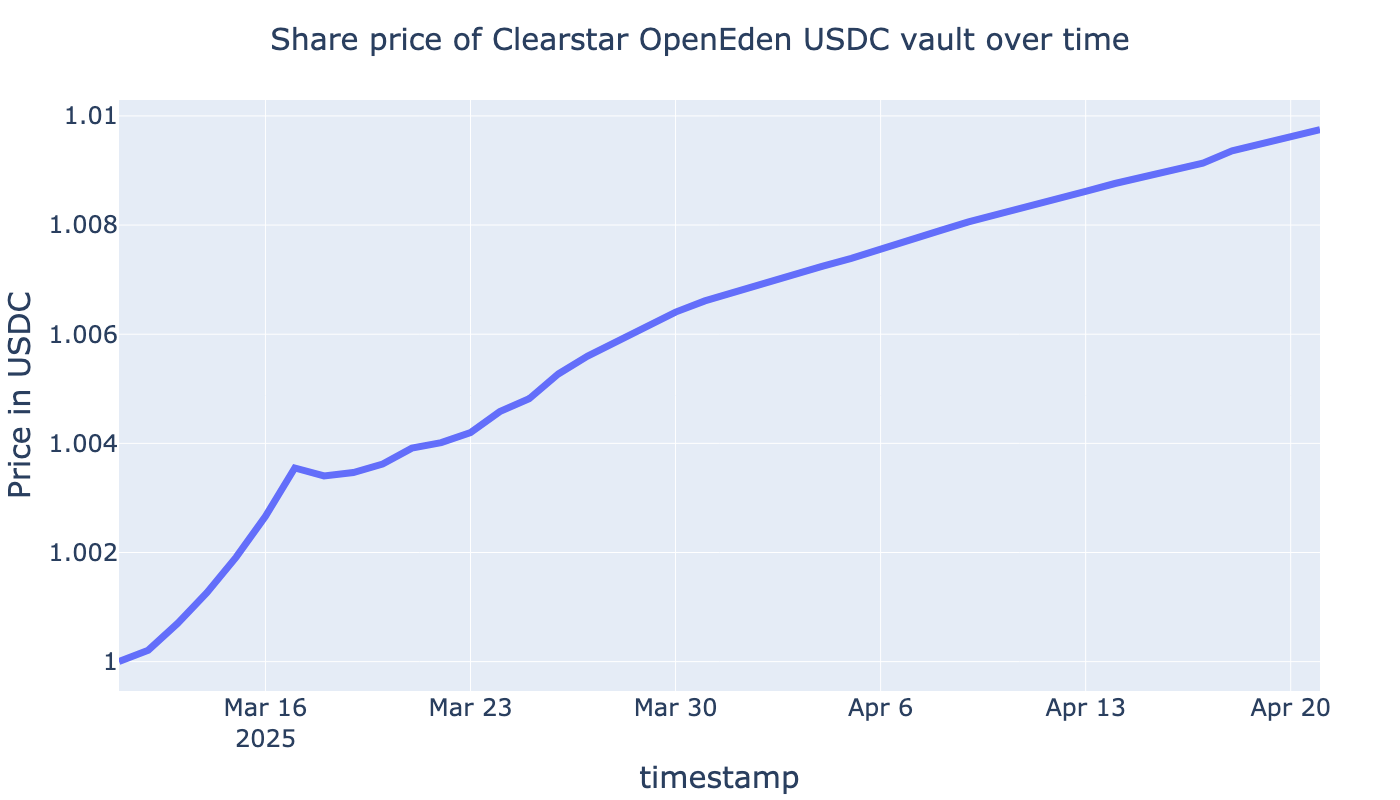

In [121]:
import plotly.express as px
price_series = vault_df["share_price"]

fig = px.line( 
    price_series, 
    title=f"Share price of {name} vault over time"
)
fig.update_layout(yaxis_title=f"Price in {vault_metadata['Denomination']}")
fig.update_layout(showlegend=False)
fig.show()

### Top vault: Net asset value

- What is the value of the all assets locked in the vault
- [Sometimes referred as TVL](https://tradingstrategy.ai/glossary/total-value-locked-tvl)



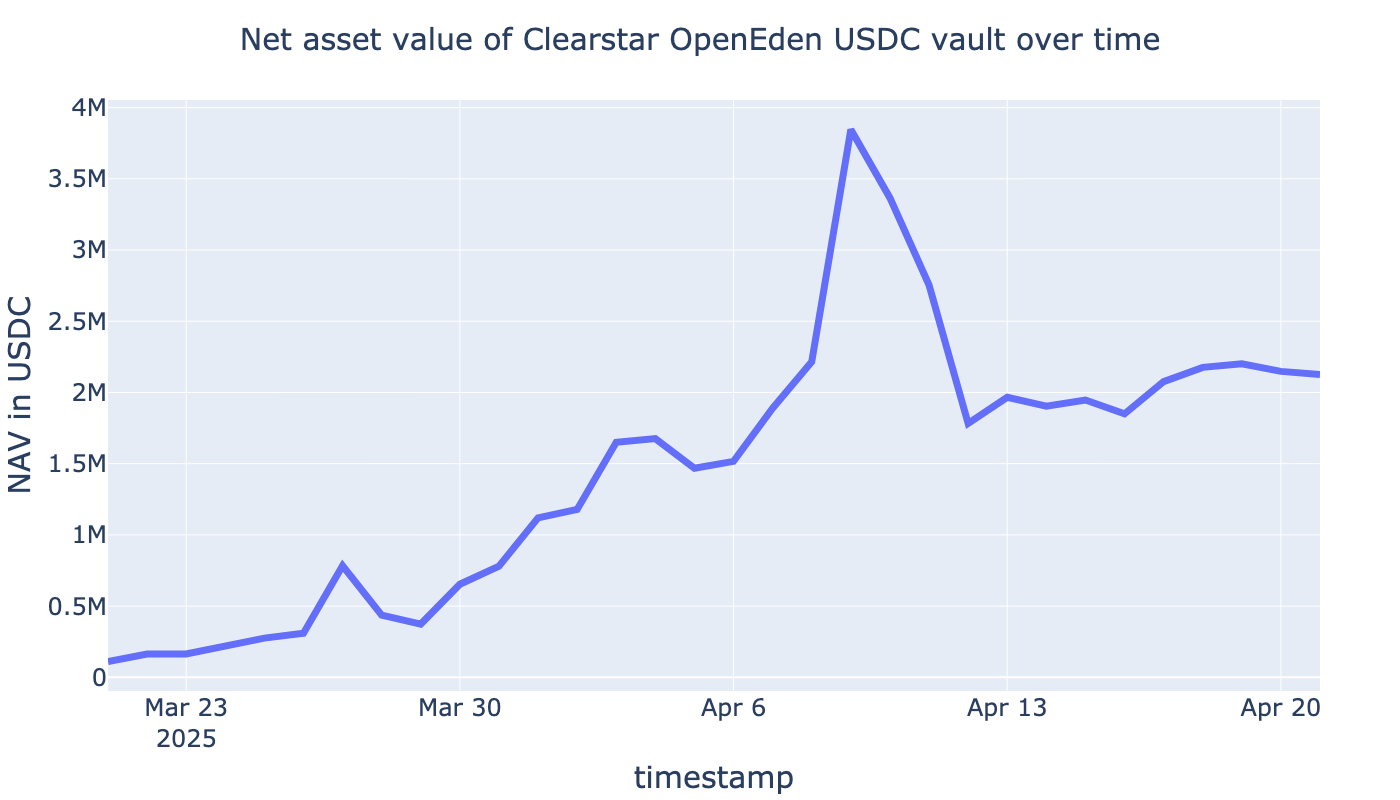

In [122]:
import plotly.express as px
nav_series = vault_df["total_assets"]

# Remove the uninteresting period when NAV is low
min_nav_threshold = 100_000
nav_series = nav_series[nav_series > min_nav_threshold]

fig = px.line( 
    nav_series, 
    title=f"Net asset value of {name} vault over time"
)
fig.update_layout(yaxis_title=f"NAV in {vault_metadata['Denomination']}")
fig.update_layout(showlegend=False)
fig.show()

### Top vault: Performance metrics

- Portfolio performance metrics for this vault

In [123]:
import warnings

with warnings.catch_warnings():  #  DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
    warnings.simplefilter(action='ignore', category=FutureWarning)  # yfinance: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
    try:
        # quantstats compatibility hack for IPython 8.x, ZMQInteractiveShell error
        # https://stackoverflow.com/a/15898875/315168
        get_ipython().magic = lambda x: x
        import quantstats
    except ImportError as e:
        quantstats = None
        

if quantstats:
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=RuntimeWarning)
        metrics = quantstats.reports.metrics
        performance_metrics_df = metrics(
            daily_returns,
            benchmark=None,
            as_pct=display,  # QuantStats codebase is a mess
            periods_per_year=365,
            mode="full",
            display=False,
            internal=True,
        )    
    print(f"Portfolio performance metrics for {name} vault") 
    performance_metrics_df.rename(columns={"Strategy": name}, inplace=True)
    display(performance_metrics_df)
else:
    print("To show the portfolio performance metrics install quantstats: pip install quantstats")
    
    

/Users/moo/Library/Caches/pypoetry/virtualenvs/trade-executor-kk5ZLC7w-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/Users/moo/Library/Caches/pypoetry/virtualenvs/trade-executor-kk5ZLC7w-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/Users/moo/Library/Caches/pypoetry/virtualenvs/trade-executor-kk5ZLC7w-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the

Portfolio performance metrics for Clearstar OpenEden USDC vault


Clearstar OpenEden USDC
Start Period                           2025-03-11
End Period                             2025-04-21
Risk-Free Rate                               0.0%
Time in Market                              98.0%
Cumulative Return                           0.97%
CAGR﹪                                       6.14%
Sharpe                                      22.76
Prob. Sharpe Ratio                              -
Smart Sharpe                                 13.3
Sortino                                    195.99
Smart Sortino                              114.48
Sortino/√2                                 138.58
Smart Sortino/√2                            80.95
Omega                                       67.48
Max Drawdown                               -0.01%
Longest DD Days                                 2
Volatility (ann.)                           0.37%
Calmar                                     420.97
Skew                                         1.66
Kurtosis                                     3.33
Expected Daily                              0.02%
Expected Monthly                            0.49%
Expected Yearly                             0.97%
Kelly Criterion                            96.12%
Risk of Ruin                                 0.0%
Daily Value-at-Risk                        -0.01%
Expected Shortfall (cVaR)                  -0.01%
Max Consecutive Wins                           34
Max Consecutive Losses                          1
Gain/Pain Ratio                             66.48
Gain/Pain (1M)                                  -
Payoff Ratio                                 1.69
Profit Factor                               67.48
Common Sense Ratio                         673.66
CPC Index                                  111.07
Tail Ratio                                   9.98
Outlier Win Ratio                            3.44
Outlier Loss Ratio                           0.59
MTD                                         0.31%
3M                                          0.97%
6M                                          0.97%
YTD                                         0.97%
1Y                                          0.97%
3Y (ann.)                                   6.14%
5Y (ann.)                                   6.14%
10Y (ann.)                                  6.14%
All-time (ann.)                             6.14%
Best Day                                    0.09%
Worst Day                                  -0.01%
Best Month                                  0.66%
Worst Month                                 0.31%
Best Year                                   0.97%
Worst Year                                  0.97%
Avg. Drawdown                              -0.01%
Avg. Drawdown Days                              2
Recovery Factor                             66.48
Ulcer Index                                   0.0
Serenity Index                            1507.18
Avg. Up Month                               0.49%
Avg. Down Month                                 -
Win Days                                   97.56%
Win Month                                  100.0%
Win Quarter                                100.0%
Win Year                                   100.0%